# Depression and Anxiety classification visualization

Based on the study by [Cavanagh et al. (2019)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6515849/)

Import packages

In [99]:
import io
import mne
import copy
import glob
import array
import matplotlib
import numpy as np
import pandas as pd
import sklearn.metrics
import seaborn as sns
import scipy.io as sio
import plotly.express as px
import matplotlib.pyplot as plt
import copy

from itertools import chain
from sklearn.svm import SVC
from scipy.io import loadmat
from sklearn import set_config

from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import permutation_test_score

from matplotlib.colors import ListedColormap

from mne.time_frequency import tfr_morlet

import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score, RepeatedStratifiedKFold
from sklearn.utils import resample

from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP

from mne.preprocessing import Xdawn
from mne.decoding import Vectorizer

from mne.decoding import UnsupervisedSpatialFilter

from sklearn.decomposition import PCA, FastICA

from scipy import stats

# parameters for plotting
plt.rcParams["figure.figsize"] = (10,7)

import seaborn as sns
sns.set_theme(style="whitegrid", palette="deep")

from mne.time_frequency import (
    tfr_multitaper,
    tfr_stockwell,
    tfr_morlet,
    tfr_array_morlet,
    AverageTFR,
)

## Load EEG data

In [2]:
data_df = pd.read_pickle("data/sonata_data/sonata_data_GNG_autoreject_freq_short.pkl")

In [3]:
dep = data_df[(data_df['BDI'] > 13) & (data_df['STAI'] > 41)]
len(dep)

75

In [4]:
ctrl_dep = data_df[(data_df['BDI'] <= 13) & (data_df['STAI'] > 41)]
len(ctrl_dep)

72

In [5]:
anx = data_df[(data_df['BDI'] <= 13) & (data_df['STAI'] > 42)]
len(anx)

65

In [6]:
ctrl_anx = data_df[(data_df['BDI'] <= 13) & (data_df['STAI'] < 41)]
len(ctrl_anx)

66

## Visualize positive feedback, negative feedback and difference waves

In [8]:
data_df.head()

id                                             epochs Demo_kod  BDI  \
0  000  <Epochs |  212 events (all good), -1 - 2.39844...      000    6   
1  012  <Epochs |  181 events (all good), -1 - 2.39844...      012   45   
2  014  <Epochs |  219 events (all good), -1 - 2.39844...      014   17   
3  037  <Epochs |  223 events (all good), -1 - 2.39844...      037   10   
4  041  <Epochs |  207 events (all good), -1 - 2.39844...      041    8   

   BDI_cognitive  BDI_affective  BDI_affect_cog  BDI_somatic  STAI  \
0           0.17           0.67            0.83         0.50    40   
1           2.33           2.00            4.33         1.67    50   
2           1.00           0.33            1.33         0.83    58   
3           0.17           1.67            1.83         0.33    51   
4           0.33           0.33            0.67         0.17    48   

                                               delta  \
0  <Epochs |  212 events (all good), 0 - 0.5 sec,...   
1  <Epochs |  181 events (all good), 0 - 0.5 sec,...   
2  <Epochs |  219 events (all good), 0 - 0.5 sec,...   
3  <Epochs |  223 events (all good), 0 - 0.5 sec,...   
4  <Epochs |  207 events (all good), 0 - 0.5 sec,...   

                                               theta  
0  <Epochs |  212 events (all good), 0 - 0.5 sec,...  
1  <Epochs |  181 events (all good), 0 - 0.5 sec,...  
2  <Epochs |  219 events (all good), 0 - 0.5 sec,...  
3  <Epochs |  223 events (all good), 0 - 0.5 sec,...  
4  <Epochs |  207 events (all good), 0 - 0.5 sec,...

In [9]:
epochs = mne.concatenate_epochs(data_df['epochs'].to_list())

/tmp/ipykernel_4613/2116549895.py:1: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs(data_df['epochs'].to_list())


Not setting metadata
45429 matching events found
No baseline correction applied


In [8]:
evokeds = [epochs[name].average().copy().crop(tmin=-0.1, tmax=0.6) for name in ('f_good', 'f_bad')]
evokeds_diff_data = evokeds[0].get_data() - evokeds[1].get_data()
evoked_diff = mne.EvokedArray(evokeds_diff_data, info = evokeds[0].info, tmin = evokeds[0].tmin,)

### Condition wavelines

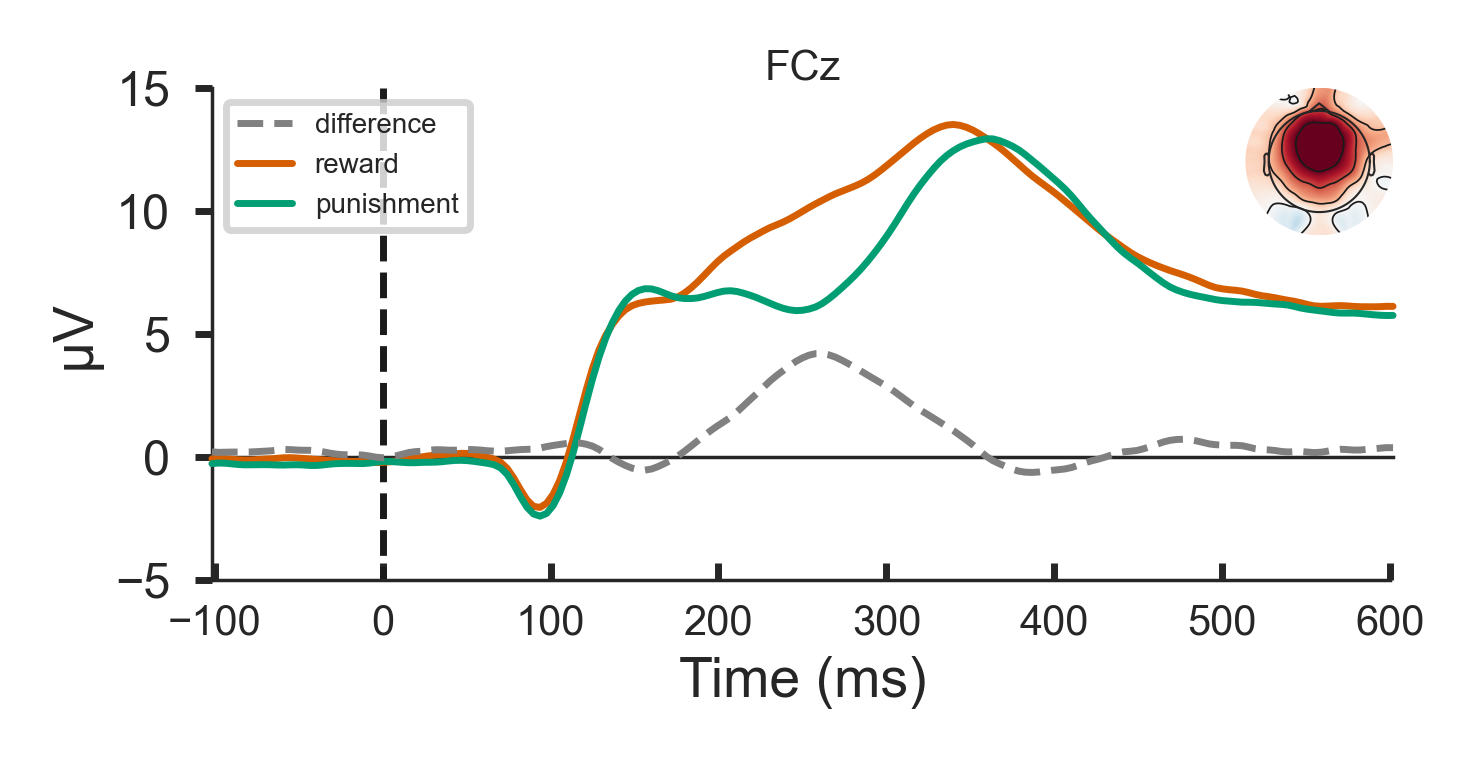

In [51]:
# evokeds_cropped = epochs.average().copy().crop(tmin=-0.1, tmax=0.6)
cm = 1/2.54
dpi = 500

plt.rc('font', size=4)
sns.set_style("ticks")


plt.rcParams['figure.dpi'] = dpi
# plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['ytick.labelsize'] = 7
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['axes.labelsize'] = 8
plt.rcParams["axes.edgecolor"] = ".15"
plt.rcParams["axes.linewidth"]  = 0.5
plt.rcParams['lines.linewidth'] = 1

plt.rcParams['axes.spines.bottom']= True
plt.rcParams['axes.spines.left']= True
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True

plt.rcParams['axes.titlesize'] = 6
plt.rcParams['figure.frameon'] = True
plt.rc('legend',fontsize=4)

plt.rcParams['axes.titlepad'] = 0.2
plt.rcParams['axes.labelpad'] = 2
plt.rcParams['axes.titlepad'] = 0.2

colors = [sns.color_palette("colorblind")[3], sns.color_palette("colorblind")[2], 'gray']
c_map = ListedColormap(sns.color_palette(colors).as_hex())
c_map = matplotlib.colors.LinearSegmentedColormap.from_list("", [sns.color_palette("colorblind")[2],sns.color_palette("colorblind")[3]])

sns.set_palette(colors)

fig = plt.figure(figsize=(6*cm, 2.5*cm))

ax = fig.add_axes([0,0,1,1], zorder=-1)

topo_axis = fig.add_axes([0.7,0.7,0.3,0.3], anchor='NE', zorder=2)
topo_axis_cbar = fig.add_axes([0.1,0.12,10,200], anchor='NE', zorder=10)

topo_fig = mne.viz.plot_evoked_topomap(
    evoked = evoked_diff,
    times = [0.25],
    vlim = (3,-3),
    show=False,
    axes=[topo_axis,topo_axis_cbar],
    sensors=False,
    outlines='head',
    # cmap=c_map,
    sphere='auto',
    extrapolate='head'
    
)

topo_axis_cbar.remove()
topo_axis.set_title('', size=7, pad=4) # Title
plt.setp(topo_axis.lines , linewidth=0.3)

fig_list = mne.viz.plot_compare_evokeds(
    {'reward':evokeds[0], 'punishment':evokeds[1], 'difference': evoked_diff},
    picks=['FCz'], 
    ci=0.95, 
    time_unit='ms',
    ylim=dict(eeg=[-5, 15]),
    show_sensors=False,
    styles={"difference": {"linestyle": '--'}},
    axes=ax,
    legend = 'upper left',
    show=False,
)

fig_list[0].axes[0].tick_params(axis='x', direction='in', length=2.5, width=1)
fig_list[0].axes[0].tick_params(axis='y', direction='out', length=2.5, width=1)


plt.show()


fig.savefig(f'data/figure_1/conditions_wave_plot_head', bbox_inches='tight', pad_inches=0.01)

### Time-frequency

In [10]:
evoked_all_conditions = epochs.average()

In [11]:
# Factor to down-sample the temporal dimension of the TFR computed by tfr_morlet.
decim = 1

# frequencies of interest in log distribution
freqs = np.linspace(0.2, 15, num=60)  
cycles = freqs / 0.8

# morelet parameters (number of cycles)
n_cycles = cycles

epochs_power = list()
tfr = list()

# perform morlet TF decomposition
tfr = tfr_morlet(evoked_all_conditions, freqs, n_cycles=n_cycles,
                      decim=decim, average=True, return_itc=False, verbose=0, n_jobs=10)

# width=0.35
# fmin, fmax = freqs[[0, -1]]
# tfr = tfr_stockwell(evokeds, fmin=fmin, fmax=fmax, width=width)
# apply baseline
# tfr.apply_baseline(mode='mean', baseline=(-0.4, -0.1), verbose=0)

# tfr = tfr_multitaper(
#         evokeds[1],
#         freqs=freqs,
#         n_cycles=n_cycles,
#         time_bandwidth=2.3,
#         return_itc=False,
# )
    
# Crop in time to keep only what is between 0 and 500 ms
# tfr.crop(0, 0.5)

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    2.9s
[Parallel(n_jobs=10)]: Done  68 out of  68 | elapsed:    3.2s finished


Applying baseline correction (mode: mean)
['−0.2', '−0.1', '0.0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7']
['0.0', '2.5', '5.0', '7.5', '10.0', '12.5']


/tmp/ipykernel_4613/165935736.py:61: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)
/tmp/ipykernel_4613/165935736.py:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels_y)


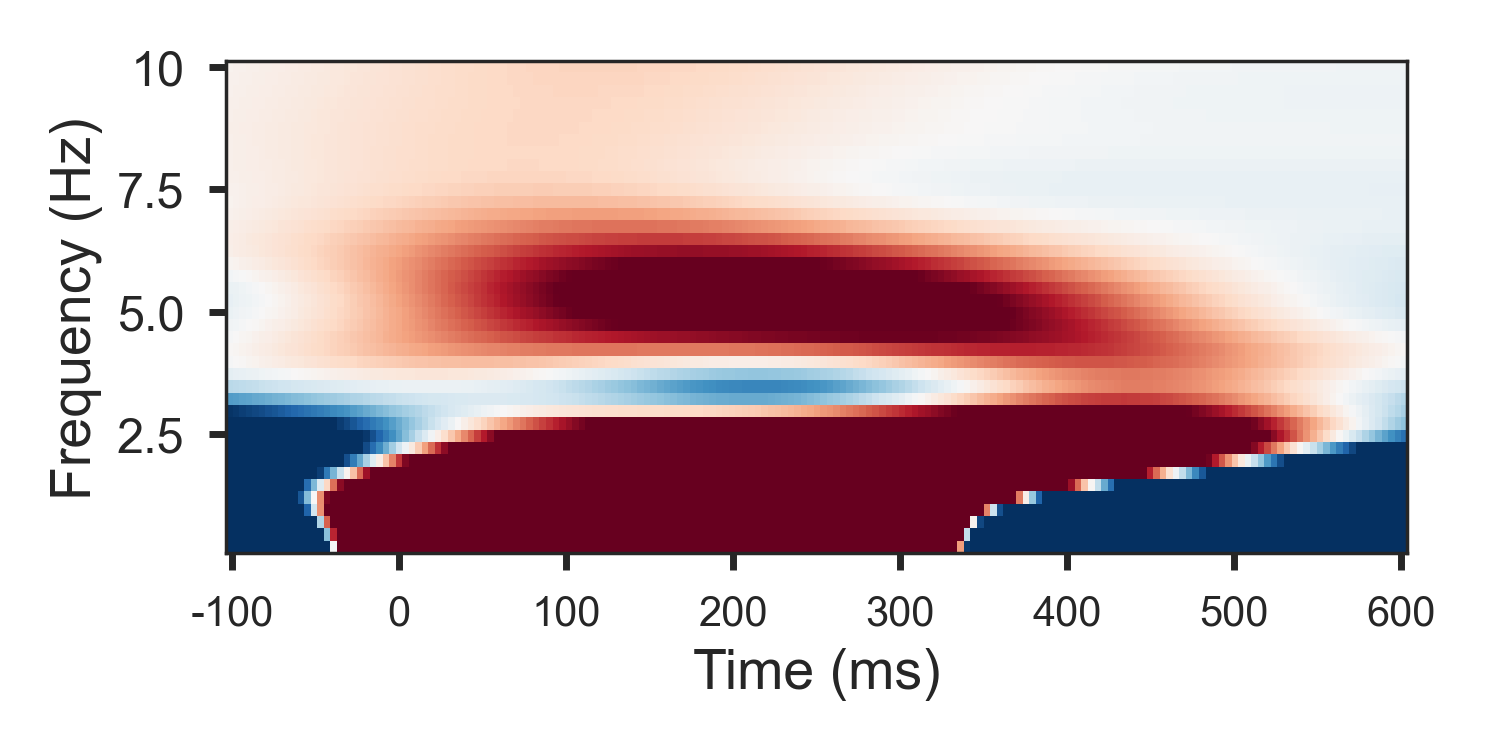

In [17]:
# evokeds_cropped = epochs.average().copy().crop(tmin=-0.1, tmax=0.6)
cm = 1/2.54
dpi = 500

plt.rc('font', size=4)
sns.set_style("ticks")


plt.rcParams['figure.dpi'] = dpi
# plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['ytick.labelsize'] = 7
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['axes.labelsize'] = 8
plt.rcParams["axes.edgecolor"] = ".15"
plt.rcParams["axes.linewidth"]  = 0.5
plt.rcParams['lines.linewidth'] = 1

plt.rcParams['axes.spines.bottom']= True
plt.rcParams['axes.spines.left']= True
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True

plt.rcParams['axes.titlesize'] = 6
plt.rcParams['figure.frameon'] = True
plt.rc('legend',fontsize=4)

plt.rcParams['axes.titlepad'] = 0.2
plt.rcParams['axes.labelpad'] = 2
plt.rcParams['axes.titlepad'] = 0.2

fig = plt.figure(figsize=(6*cm, 2.5*cm))

ax = fig.add_axes([0,0,1,1], zorder=-1)

tfr.plot(
    ['FCz'],
    baseline=(-0.9, 0), 
    mode="mean", 
    show=False, 
    # colorbar=True,
    vmin=-1e-10,
    vmax=1e-10,
    tmin=-0.1, 
    tmax=0.6,
    axes=ax,
    colorbar=False,
    fmin=0,
    fmax=10,
)

labels = [item.get_text() for item in ax.get_xticklabels()]
print(labels)
labels[1] = '-100'
labels[2] = '0'
labels[3] = '100'
labels[4] = '200'
labels[5] = '300'
labels[6] = '400'
labels[7] = '500'
labels[8] = '600'
ax.set_xticklabels(labels)

labels_y = [item.get_text() for item in ax.get_yticklabels()]
print(labels_y)
labels_y[4] = 10
ax.set_yticklabels(labels_y)


plt.xlabel('Time (ms)')

ax.tick_params(axis='x', direction='out', length=2.5, width=1)
ax.tick_params(axis='y', direction='out', length=2.5, width=1)

plt.show()
fig.savefig(f'data/figure_1/tfr_600', bbox_inches='tight', pad_inches=0.01)

### Theta and delta plots per groups

- depression

In [59]:
depression_epochs = mne.concatenate_epochs(dep['delta'].to_list())
depression_ctr_epochs = mne.concatenate_epochs(ctrl_dep['delta'].to_list())

/tmp/ipykernel_7098/2216668141.py:1: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  depression_epochs = mne.concatenate_epochs(dep['delta'].to_list())


Not setting metadata
15368 matching events found
No baseline correction applied


/tmp/ipykernel_7098/2216668141.py:2: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  depression_ctr_epochs = mne.concatenate_epochs(ctrl_dep['delta'].to_list())


Not setting metadata
14688 matching events found
No baseline correction applied


In [65]:
evokeds_dep = [depression_epochs[name].average().copy().crop(tmin=0.0, tmax=0.5) for name in ('f_good', 'f_bad')]
evokeds_dep_ctr = [depression_ctr_epochs[name].average().copy().crop(tmin=0.0, tmax=0.5) for name in ('f_good', 'f_bad')]

evokeds = {
    'reward DEP': evokeds_dep[0],
    'reward CTR': evokeds_dep_ctr[0],
    'punishment DEP' : evokeds_dep[1],
    'punishment CTR' : evokeds_dep_ctr[1],
}

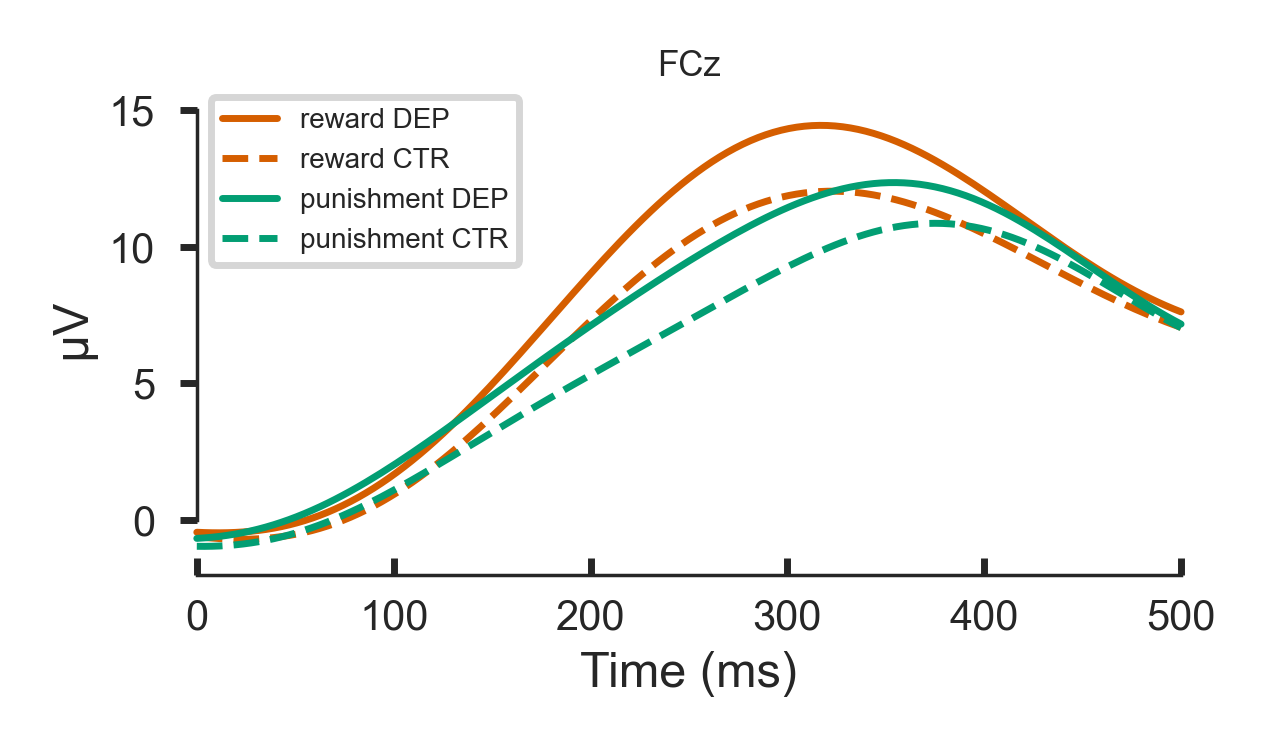

In [71]:
cm = 1/2.54
dpi = 500

plt.rc('font', size=4)
sns.set_style("ticks")


plt.rcParams['figure.dpi'] = dpi
# plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['ytick.labelsize'] = 6
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['axes.labelsize'] = 7
plt.rcParams["axes.edgecolor"] = ".15"
plt.rcParams["axes.linewidth"]  = 0.5
plt.rcParams['lines.linewidth'] = 1

plt.rcParams['axes.spines.bottom']= True
plt.rcParams['axes.spines.left']= True
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True

plt.rcParams['axes.titlesize'] = 5
plt.rcParams['figure.frameon'] = True
plt.rc('legend',fontsize=4)

plt.rcParams['axes.titlepad'] = 0.2
plt.rcParams['axes.labelpad'] = 2
plt.rcParams['axes.titlepad'] = 0.2



# sns.set_palette('Paired')

# colors = [sns.color_palette("colorblind")[3], sns.color_palette("colorblind")[2], 'gray']
# sns.set_palette(colors)

picks = ["FCz"]

# fig = plt.figure()
# ax = fig.add_axes([0, 0, 0.78, 0.78])

fig = plt.figure(figsize=(5*cm, 2.5*cm))

ax = fig.add_axes([0,0,1,1], zorder=-1)
# topo_rewP_axis = fig.add_axes([0.76,0.67,0.32,0.32], zorder=1000)
# topo_FRN_axis = fig.add_axes([0.76,0.02,0.32,0.32], zorder=10000)


# rewp_fig, rewP_cont = mne.viz.plot_topomap(
#     rewp_delta_contrast.reshape(-1), 
#     evokeds_dep[0].info, 
#     show=False, 
#     res=1000, 
#     sensors=False,
#     axes=topo_rewP_axis
# )
# plt.setp(rewP_cont.collections , linewidth=0.5)
# plt.setp(topo_rewP_axis.lines , linewidth=0.5)


# frn_fig, frn_cont = mne.viz.plot_topomap(
#     frn_delta_contrast.reshape(-1), 
#     evokeds_dep[0].info, 
#     show=False, 
#     res=1000, 
#     sensors=False,
#     axes=topo_FRN_axis
# )
# plt.setp(frn_cont.collections , linewidth=0.5)
# plt.setp(topo_FRN_axis.lines , linewidth=0.5)



a = mne.viz.plot_compare_evokeds(
    evokeds, 
    picks=picks, 
    ci=0.95, 
    ylim=dict(eeg=[-2, 16]),
    axes=ax,
    time_unit='ms',
    show_sensors=False,
    show=False,
    styles={
        "reward DEP": {"linestyle": '-'},
        "reward CTR": {"linestyle": '--'},
        "punishment DEP": {"linestyle": '-'},
        "punishment CTR": {"linestyle": '--'},

    },
    colors = [sns.color_palette("colorblind")[3],sns.color_palette("colorblind")[3],sns.color_palette("colorblind")[2],sns.color_palette("colorblind")[2]]

    
    
)

ax.tick_params(axis='x', direction='in', length=2.5, width=1)
ax.tick_params(axis='y', direction='out', length=2.5, width=1)


plt.show()

fig.savefig(f'data/figure_1/delta_dep_smaller', bbox_inches='tight', pad_inches=0.01)

In [72]:
depression_epochs = mne.concatenate_epochs(dep['theta'].to_list())
depression_ctr_epochs = mne.concatenate_epochs(ctrl_dep['theta'].to_list())

/tmp/ipykernel_7098/3861393698.py:1: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  depression_epochs = mne.concatenate_epochs(dep['theta'].to_list())


Not setting metadata
15368 matching events found
No baseline correction applied


/tmp/ipykernel_7098/3861393698.py:2: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  depression_ctr_epochs = mne.concatenate_epochs(ctrl_dep['theta'].to_list())


Not setting metadata
14688 matching events found
No baseline correction applied


In [73]:
evokeds_dep = [depression_epochs[name].average().crop(tmin=0.0, tmax=0.5) for name in ('f_good', 'f_bad')]
evokeds_dep_ctr = [depression_ctr_epochs[name].average().crop(tmin=-0.0, tmax=0.5) for name in ('f_good', 'f_bad')]

evokeds = {
    'reward DEP': evokeds_dep[0],
    'reward CTR': evokeds_dep_ctr[0],
    'punishment DEP' : evokeds_dep[1],
    'punishment CTR' : evokeds_dep_ctr[1],
}

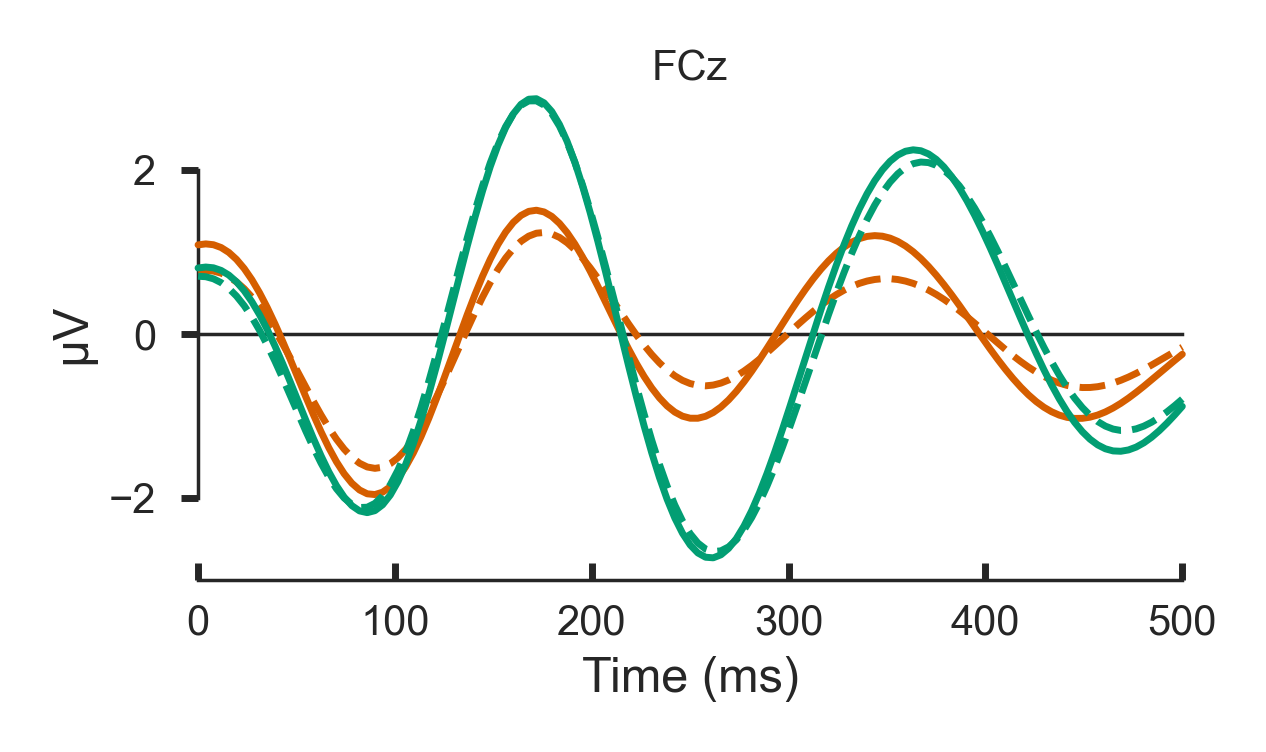

In [78]:
cm = 1/2.54
dpi = 500

plt.rc('font', size=4)
sns.set_style("ticks")


plt.rcParams['figure.dpi'] = dpi
# plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['ytick.labelsize'] = 6
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['axes.labelsize'] = 7
plt.rcParams["axes.edgecolor"] = ".15"
plt.rcParams["axes.linewidth"]  = 0.5
plt.rcParams['lines.linewidth'] = 1

plt.rcParams['axes.spines.bottom']= True
plt.rcParams['axes.spines.left']= True
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True

plt.rcParams['axes.titlesize'] = 5
plt.rcParams['figure.frameon'] = True
plt.rc('legend',fontsize=4)

plt.rcParams['axes.titlepad'] = 0.2
plt.rcParams['axes.labelpad'] = 2
plt.rcParams['axes.titlepad'] = 0.2



# sns.set_palette('Paired')

# colors = [sns.color_palette("colorblind")[3], sns.color_palette("colorblind")[2], 'gray']
# sns.set_palette(colors)

picks = ["FCz"]

# fig = plt.figure()
# ax = fig.add_axes([0, 0, 0.78, 0.78])

fig = plt.figure(figsize=(5*cm, 2.5*cm))

ax = fig.add_axes([0,0,1,1], zorder=-1)
# topo_rewP_axis = fig.add_axes([0.76,0.67,0.32,0.32], zorder=1000)
# topo_FRN_axis = fig.add_axes([0.76,0.02,0.32,0.32], zorder=10000)


# rewp_fig, rewP_cont = mne.viz.plot_topomap(
#     rewp_delta_contrast.reshape(-1), 
#     evokeds_dep[0].info, 
#     show=False, 
#     res=1000, 
#     sensors=False,
#     axes=topo_rewP_axis
# )
# plt.setp(rewP_cont.collections , linewidth=0.5)
# plt.setp(topo_rewP_axis.lines , linewidth=0.5)


# frn_fig, frn_cont = mne.viz.plot_topomap(
#     frn_delta_contrast.reshape(-1), 
#     evokeds_dep[0].info, 
#     show=False, 
#     res=1000, 
#     sensors=False,
#     axes=topo_FRN_axis
# )
# plt.setp(frn_cont.collections , linewidth=0.5)
# plt.setp(topo_FRN_axis.lines , linewidth=0.5)



a = mne.viz.plot_compare_evokeds(
    evokeds, 
    picks=picks, 
    ci=0.95, 
    ylim=dict(eeg=[-3, 3]),
    axes=ax,
    time_unit='ms',
    show_sensors=False,
    show=False,
    legend=False,
    styles={
        "reward DEP": {"linestyle": '-'},
        "reward CTR": {"linestyle": '--'},
        "punishment DEP": {"linestyle": '-'},
        "punishment CTR": {"linestyle": '--'},

    },
    colors = [sns.color_palette("colorblind")[3],sns.color_palette("colorblind")[3],sns.color_palette("colorblind")[2],sns.color_palette("colorblind")[2]]

    
    
)
ax.tick_params(axis='x', direction='in', length=2.5, width=1)
ax.tick_params(axis='y', direction='out', length=2.5, width=1)

plt.show()

fig.savefig(f'data/figure_1/theta_dep_smaller', bbox_inches='tight', pad_inches=0.01)

- anxiety

In [19]:
depression_epochs = mne.concatenate_epochs(anx['delta'].to_list())
depression_ctr_epochs = mne.concatenate_epochs(ctrl_anx['delta'].to_list())

/tmp/ipykernel_4613/1072237204.py:1: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  depression_epochs = mne.concatenate_epochs(anx['delta'].to_list())


Not setting metadata
14688 matching events found
No baseline correction applied


/tmp/ipykernel_4613/1072237204.py:2: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  depression_ctr_epochs = mne.concatenate_epochs(ctrl_anx['delta'].to_list())


Not setting metadata
13523 matching events found
No baseline correction applied


In [20]:
evokeds_dep = [depression_epochs[name].average().copy().crop(tmin=0.0, tmax=0.5) for name in ('f_good', 'f_bad')]
evokeds_dep_ctr = [depression_ctr_epochs[name].average().copy().crop(tmin=0.0, tmax=0.5) for name in ('f_good', 'f_bad')]

evokeds = {
    'reward ANX': evokeds_dep[0],
    'reward CTR': evokeds_dep_ctr[0],
    'punishment ANX' : evokeds_dep[1],
    'punishment CTR' : evokeds_dep_ctr[1],
}

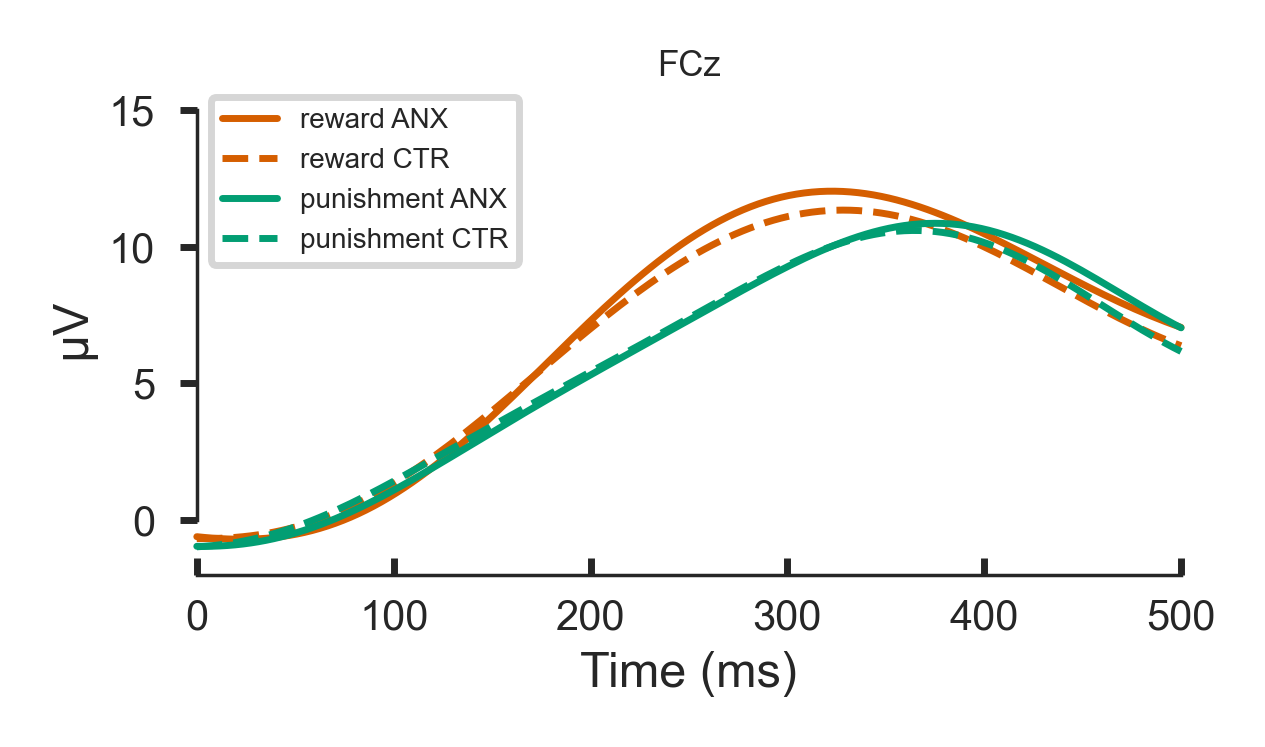

In [21]:
cm = 1/2.54
dpi = 500

plt.rc('font', size=4)
sns.set_style("ticks")


plt.rcParams['figure.dpi'] = dpi
# plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['ytick.labelsize'] = 6
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['axes.labelsize'] = 7
plt.rcParams["axes.edgecolor"] = ".15"
plt.rcParams["axes.linewidth"]  = 0.5
plt.rcParams['lines.linewidth'] = 1

plt.rcParams['axes.spines.bottom']= True
plt.rcParams['axes.spines.left']= True
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True

plt.rcParams['axes.titlesize'] = 5
plt.rcParams['figure.frameon'] = True
plt.rc('legend',fontsize=4)

plt.rcParams['axes.titlepad'] = 0.2
plt.rcParams['axes.labelpad'] = 2
plt.rcParams['axes.titlepad'] = 0.2



# sns.set_palette('Paired')

# colors = [sns.color_palette("colorblind")[3], sns.color_palette("colorblind")[2], 'gray']
# sns.set_palette(colors)

picks = ["FCz"]

# fig = plt.figure()
# ax = fig.add_axes([0, 0, 0.78, 0.78])

# fig = plt.figure(figsize=(4.5*cm, 2.5*cm))
fig = plt.figure(figsize=(5*cm, 2.5*cm))


ax = fig.add_axes([0,0,1,1], zorder=-1)
# topo_rewP_axis = fig.add_axes([0.76,0.67,0.32,0.32], zorder=1000)
# topo_FRN_axis = fig.add_axes([0.76,0.02,0.32,0.32], zorder=10000)


# rewp_fig, rewP_cont = mne.viz.plot_topomap(
#     rewp_delta_contrast.reshape(-1), 
#     evokeds_dep[0].info, 
#     show=False, 
#     res=1000, 
#     sensors=False,
#     axes=topo_rewP_axis
# )
# plt.setp(rewP_cont.collections , linewidth=0.5)
# plt.setp(topo_rewP_axis.lines , linewidth=0.5)


# frn_fig, frn_cont = mne.viz.plot_topomap(
#     frn_delta_contrast.reshape(-1), 
#     evokeds_dep[0].info, 
#     show=False, 
#     res=1000, 
#     sensors=False,
#     axes=topo_FRN_axis
# )
# plt.setp(frn_cont.collections , linewidth=0.5)
# plt.setp(topo_FRN_axis.lines , linewidth=0.5)



a = mne.viz.plot_compare_evokeds(
    evokeds, 
    picks=picks, 
    ci=0.95, 
    ylim=dict(eeg=[-2, 16]),
    axes=ax,
    time_unit='ms',
    show_sensors=False,
    show=False,
    styles={
        "reward ANX": {"linestyle": '-'},
        "reward CTR": {"linestyle": '--'},
        "punishment ANX": {"linestyle": '-'},
        "punishment CTR": {"linestyle": '--'},

    },
    colors = [sns.color_palette("colorblind")[3],sns.color_palette("colorblind")[3],sns.color_palette("colorblind")[2],sns.color_palette("colorblind")[2]]

    
    
)

ax.tick_params(axis='x', direction='in', length=2.5, width=1)
ax.tick_params(axis='y', direction='out', length=2.5, width=1)

plt.show()

fig.savefig(f'data/figure_1/delta_anx_smaller', bbox_inches='tight', pad_inches=0.01)

In [86]:
depression_epochs = mne.concatenate_epochs(anx['theta'].to_list())
depression_ctr_epochs = mne.concatenate_epochs(ctrl_anx['theta'].to_list())

/tmp/ipykernel_7098/1184506707.py:1: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  depression_epochs = mne.concatenate_epochs(anx['theta'].to_list())


Not setting metadata
14688 matching events found
No baseline correction applied


/tmp/ipykernel_7098/1184506707.py:2: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  depression_ctr_epochs = mne.concatenate_epochs(ctrl_anx['theta'].to_list())


Not setting metadata
13523 matching events found
No baseline correction applied


In [87]:
evokeds_dep = [depression_epochs[name].average().crop(tmin=0.0, tmax=0.5) for name in ('f_good', 'f_bad')]
evokeds_dep_ctr = [depression_ctr_epochs[name].average().crop(tmin=-0.0, tmax=0.5) for name in ('f_good', 'f_bad')]

evokeds = {
    'reward ANX': evokeds_dep[0],
    'reward CTR': evokeds_dep_ctr[0],
    'punishment ANX' : evokeds_dep[1],
    'punishment CTR' : evokeds_dep_ctr[1],
}

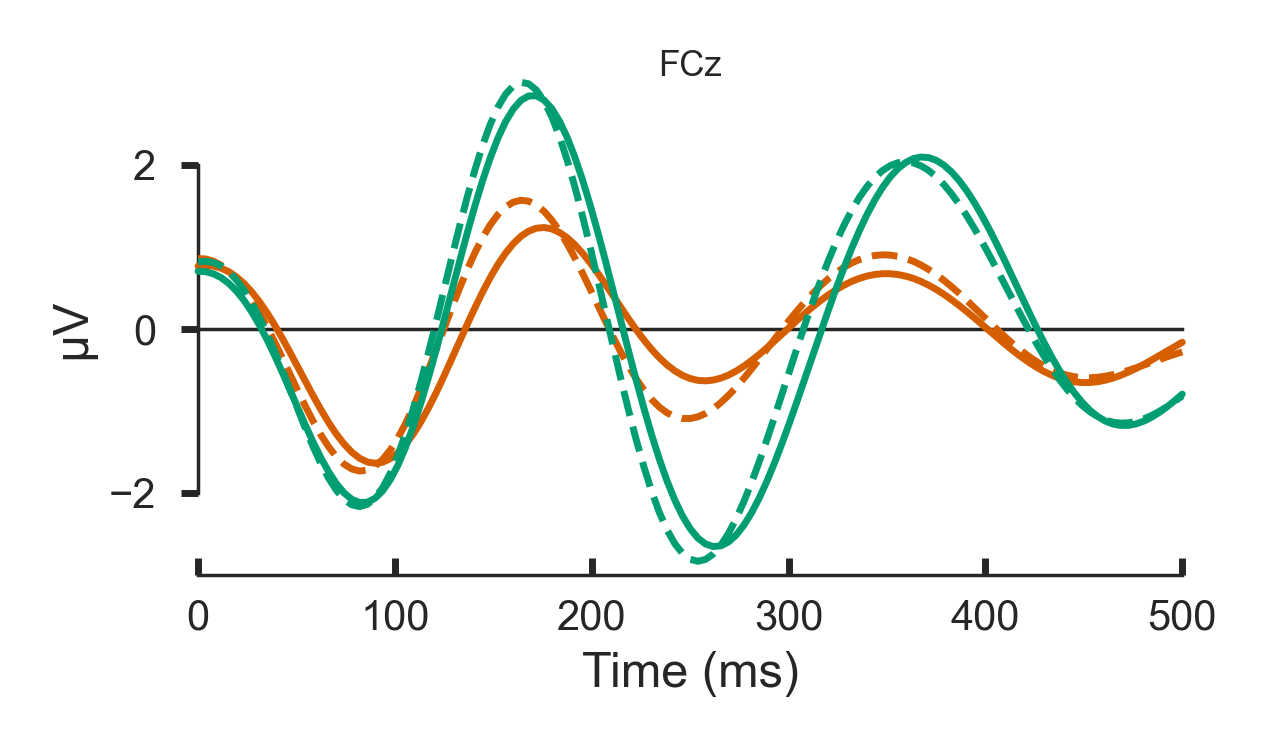

In [90]:
cm = 1/2.54
dpi = 500

plt.rc('font', size=4)
sns.set_style("ticks")


plt.rcParams['figure.dpi'] = dpi
# plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['ytick.labelsize'] = 6
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['axes.labelsize'] = 7
plt.rcParams["axes.edgecolor"] = ".15"
plt.rcParams["axes.linewidth"]  = 0.5
plt.rcParams['lines.linewidth'] = 1

plt.rcParams['axes.spines.bottom']= True
plt.rcParams['axes.spines.left']= True
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True

plt.rcParams['axes.titlesize'] = 5
plt.rcParams['figure.frameon'] = True
plt.rc('legend',fontsize=3)

plt.rcParams['axes.titlepad'] = 0.2
plt.rcParams['axes.labelpad'] = 2
plt.rcParams['axes.titlepad'] = 0.2



# sns.set_palette('Paired')

# colors = [sns.color_palette("colorblind")[3], sns.color_palette("colorblind")[2], 'gray']
# sns.set_palette(colors)

picks = ["FCz"]

# fig = plt.figure()
# ax = fig.add_axes([0, 0, 0.78, 0.78])

# fig = plt.figure(figsize=(4.5*cm, 2.5*cm))
fig = plt.figure(figsize=(5*cm, 2.5*cm))


ax = fig.add_axes([0,0,1,1], zorder=-1)
# topo_rewP_axis = fig.add_axes([0.76,0.67,0.32,0.32], zorder=1000)
# topo_FRN_axis = fig.add_axes([0.76,0.02,0.32,0.32], zorder=10000)


# rewp_fig, rewP_cont = mne.viz.plot_topomap(
#     rewp_delta_contrast.reshape(-1), 
#     evokeds_dep[0].info, 
#     show=False, 
#     res=1000, 
#     sensors=False,
#     axes=topo_rewP_axis
# )
# plt.setp(rewP_cont.collections , linewidth=0.5)
# plt.setp(topo_rewP_axis.lines , linewidth=0.5)


# frn_fig, frn_cont = mne.viz.plot_topomap(
#     frn_delta_contrast.reshape(-1), 
#     evokeds_dep[0].info, 
#     show=False, 
#     res=1000, 
#     sensors=False,
#     axes=topo_FRN_axis
# )
# plt.setp(frn_cont.collections , linewidth=0.5)
# plt.setp(topo_FRN_axis.lines , linewidth=0.5)



a = mne.viz.plot_compare_evokeds(
    evokeds, 
    picks=picks, 
    ci=0.95, 
    ylim=dict(eeg=[-3, 3]),
    axes=ax,
    time_unit='ms',
    show_sensors=False,
    show=False,
    legend=False,
    styles={
        "reward ANX": {"linestyle": '-'},
        "reward CTR": {"linestyle": '--'},
        "punishment ANX": {"linestyle": '-'},
        "punishment CTR": {"linestyle": '--'},

    },
    colors = [sns.color_palette("colorblind")[3],sns.color_palette("colorblind")[3],sns.color_palette("colorblind")[2],sns.color_palette("colorblind")[2]]

    
    
)

ax.tick_params(axis='x', direction='in', length=2.5, width=1)
ax.tick_params(axis='y', direction='out', length=2.5, width=1)

plt.show()


fig.savefig(f'data/figure_1/theta_anx_smaller', bbox_inches='tight', pad_inches=0.01)

---

### CSP components patterns visualization

In [14]:
tmin = 0.20
tmax = 0.30

In [15]:
picks=['']

In [16]:
rewp_depression_datasets = []
frequencies = ['delta', 'theta']

for freq in frequencies:
    dep_data = [mne.filter.resample(epoch['f_good'].average().get_data(tmin=tmin, tmax=tmax,), down=1.0) for epoch in dep[freq].to_numpy()]
    ctrl_data = [mne.filter.resample(epoch['f_good'].average().get_data(tmin=tmin, tmax=tmax,), down=1.0) for epoch in ctrl_dep[freq].to_numpy()]

    X = np.array(dep_data + ctrl_data)
    rewp_depression_datasets.append(X)

In [17]:
frn_depression_datasets = []
frequencies = ['delta', 'theta']

for freq in frequencies:
    dep_data = [epoch['f_bad'].average().get_data(tmin=tmin, tmax=tmax,) for epoch in dep[freq].to_numpy()]
    ctrl_data = [epoch['f_bad'].average().get_data(tmin=tmin, tmax=tmax,) for epoch in ctrl_dep[freq].to_numpy()]

    X = np.array(dep_data + ctrl_data)
    frn_depression_datasets.append(X)

In [18]:
rewp_anxiety_datasets = []
frequencies = ['delta', 'theta']

for freq in frequencies:
    anx_data = [epoch['f_good'].average().get_data(tmin=tmin, tmax=tmax,) for epoch in anx[freq].to_numpy()]
    ctrl_data = [epoch['f_good'].average().get_data(tmin=tmin, tmax=tmax,) for epoch in ctrl_anx[freq].to_numpy()]

    X = np.array(anx_data + ctrl_data)
    rewp_anxiety_datasets.append(X)

In [19]:
frn_anxiety_datasets = []
frequencies = ['delta', 'theta']

for freq in frequencies:
    anx_data = [epoch['f_bad'].average().get_data(tmin=tmin, tmax=tmax,) for epoch in anx[freq].to_numpy()]
    ctrl_data = [epoch['f_bad'].average().get_data(tmin=tmin, tmax=tmax,) for epoch in ctrl_anx[freq].to_numpy()]

    X = np.array(anx_data + ctrl_data)
    frn_anxiety_datasets.append(X)

In [20]:
results_dep_rewp_df = pd.read_pickle("data/sonata_data/results/GNG/depression_rewp_freq_results_t20-t30_01_06_sonata.pkl")
results_dep_frn_df = pd.read_pickle("data/sonata_data/results/GNG/depression_frn_results_freq_t20-t30_01_06_sonata.pkl")
results_anx_rewp_df = pd.read_pickle("data/sonata_data/results/GNG/anxiety_rewp_freq_results_t20-t30_01_06_sonata.pkl")
results_anx_frn_df = pd.read_pickle("data/sonata_data/results/GNG/anxiety_frn_freq_results_t20-t30_01_06_sonata.pkl")

In [21]:
dep_rewp_delta_model_csp = results_dep_rewp_df.iloc[0].best_model[0]
dep_rewp_theta_model_csp = results_dep_rewp_df.iloc[1].best_model[0]
dep_frn_delta_model_csp = results_dep_frn_df.iloc[0].best_model[0]
dep_frn_theta_model_csp = results_dep_frn_df.iloc[1].best_model[0]

anx_rewp_delta_model_csp = results_anx_rewp_df.iloc[0].best_model[0]
anx_rewp_theta_model_csp = results_anx_rewp_df.iloc[1].best_model[0]
anx_frn_delta_model_csp = results_anx_frn_df.iloc[0].best_model[0]
anx_frn_theta_model_csp = results_anx_frn_df.iloc[1].best_model[0]

In [110]:
def plot_csp(info, csp, data, epochs, figname='out'):
    # plot CSP patterns estimated on full data for visualization
    cm = 1/2.54
    dpi = 500

    plt.rc('font', size=5)
    sns.set_style("ticks")


    plt.rcParams['figure.dpi'] = dpi
    # plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams['ytick.labelsize'] = 6
    plt.rcParams['xtick.labelsize'] = 6
    plt.rcParams['axes.labelsize'] = 7
    plt.rcParams["axes.edgecolor"] = ".15"
    plt.rcParams["axes.linewidth"]  = 0.5
    plt.rcParams['lines.linewidth'] = 1

    plt.rcParams['axes.spines.bottom']= True
    plt.rcParams['axes.spines.left']= True
    plt.rcParams['axes.spines.right'] = True
    plt.rcParams['axes.spines.top'] = True

    plt.rcParams['axes.titlesize'] = 5
    plt.rcParams['figure.frameon'] = True
    plt.rc('legend',fontsize=3)

    plt.rcParams['axes.titlepad'] = 0.2
    plt.rcParams['axes.labelpad'] = 2
    plt.rcParams['axes.titlepad'] = 0.2

    fig = plt.figure(figsize=(5*cm, 2.5*cm))
    # ax = fig.add_axes([0,0,1,1], zorder=-1)
    
    chs = np.array(info.ch_names)
    channels_to_remove = np.array(['EXG1','EXG2','EXG3','EXG4', 'P9', 'Iz', 'P10'])
    indexes = (chs[:, None] == channels_to_remove).argmax(axis=0)

    info_new = epochs.iloc[0].epochs.copy().crop(tmin,tmax).pick('eeg').drop_channels(channels_to_remove).info

    patterns = csp.patterns_
    patterns_new = np.delete(patterns, indexes, 0)
    patterns_new = np.delete(patterns_new, indexes, 1)

    new_csp = copy.deepcopy(csp)
    new_csp.patterns_ = patterns_new


    a = new_csp.plot_patterns(
        info_new, 
        ch_type="eeg",
        # extrapolate='box',
        # border=0.0,
        units="Patterns (AU)", 
        show=False,
        colorbar=False,
        res=dpi, 
        size=1.5*cm
    )

    # plt.show()
    
    plt.savefig(f'data/figure_1_new/{figname}', bbox_inches='tight', pad_inches=0.01)
    
    plt.show()


In [153]:
def plot_differences_betten_groups_CSP_space(csp, X_1, X_2, labels, info, epochs, vlim=(None,None), figname=None):
     # plot CSP patterns estimated on full data for visualization
    cm = 1/2.54
    dpi = 500

    plt.rc('font', size=5)
    sns.set_style("ticks")


    plt.rcParams['figure.dpi'] = dpi
    # plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams['ytick.labelsize'] = 6
    plt.rcParams['xtick.labelsize'] = 6
    plt.rcParams['axes.labelsize'] = 7
    plt.rcParams["axes.edgecolor"] = ".15"
    plt.rcParams["axes.linewidth"]  = 0.5
    plt.rcParams['lines.linewidth'] = 1

    plt.rcParams['axes.spines.bottom']= True
    plt.rcParams['axes.spines.left']= True
    plt.rcParams['axes.spines.right'] = True
    plt.rcParams['axes.spines.top'] = True

    plt.rcParams['axes.titlesize'] = 5
    plt.rcParams['figure.frameon'] = True
    plt.rc('legend',fontsize=3)

    plt.rcParams['axes.titlepad'] = 0.2
    plt.rcParams['axes.labelpad'] = 2
    plt.rcParams['axes.titlepad'] = 0.2

    n_components = csp.n_components
    
    ######
    chs = np.array(info.ch_names)
    channels_to_remove = np.array(['EXG1','EXG2','EXG3','EXG4', 'P9', 'Iz', 'P10'])
    indexes = (chs[:, None] == channels_to_remove).argmax(axis=0)

    info_new = epochs.iloc[0].epochs.copy().crop(tmin,tmax).pick('eeg').drop_channels(channels_to_remove).info

    filters_ = csp.filters_
    filters_new = np.delete(filters_, indexes, 0)
    filters_new = np.delete(filters_, indexes, 1)

    new_csp = copy.deepcopy(csp)
    new_csp.filters_ = filters_new
    
    X_1_new = np.delete(np.array(X_1), indexes, 1)
    X_2_new = np.delete(np.array(X_2), indexes, 1)
    
    #####
    filters = new_csp.filters_[:n_components]
        
    diff_ = np.mean(X_1_new, axis=0) - np.mean(X_2_new, axis=0) # diff between averages of groups
    diff_ = np.mean(diff_, axis=-1) # average in time-window
    diff_filtered_ = diff_ * filters
    
    X_1_filtered = np.mean(np.mean(X_1_new, axis=0), axis=-1) * filters
    X_2_filtered = np.mean(np.mean(X_2_new, axis=0), axis=-1) * filters
    

    # fig = plt.figure(figsize=(5*cm, 2.5*cm))
    # ax = fig.add_axes([0,0,1,1], zorder=-1)
    fig, contours = mne.viz.plot_topomap(
            diff_, 
            info_new, 
            show=False, 
            res=dpi, 
            contours=3, 
            size=1.5*cm,
            # vlim=vlim,
            # axes= axes[0][0]
    )
    plt.setp(contours.collections , linewidth=0.2)
    plt.setp(fig.axes.lines , linewidth=0.5)
    
    gridspec_kw = {
        'wspace':0.02,
        'hspace':0.07,
    }

    fig, axes = plt.subplots(3, n_components,figsize=(n_components*2*cm, 5*cm), gridspec_kw=gridspec_kw)

    for index in range(0,n_components):
        ax_ = axes[2][index] if n_components > 1 else axes[0]
        
        print(np.mean(diff_filtered_[index]))
        
        fig_csp, contours = mne.viz.plot_topomap(
            diff_filtered_[index], 
            info_new, 
            show=False, 
            res=dpi, 
            contours=3, 
            size=3*cm,
            vlim=vlim,
            axes= ax_,
            sensors=False,
        )
        
        plt.setp(contours.collections , linewidth=0.2)
        plt.setp(ax_.lines , linewidth=0.5)
        
        ax_ = axes[0][index] if n_components > 1 else axes[1]

        fig_csp_2, contours = mne.viz.plot_topomap(
            X_1_filtered[index], 
            info_new, 
            show=False, 
            res=dpi, 
            contours=3, 
            size=1.5*cm,
            vlim=vlim,
            axes= ax_,
            sensors=False,
        )
        plt.setp(contours.collections , linewidth=0.2)
        plt.setp(ax_.lines , linewidth=0.5)
        
        ax_ = axes[1][index] if n_components > 1 else axes[2]

        fig_csp_3, contours = mne.viz.plot_topomap(
            X_2_filtered[index], 
            info_new, 
            show=False, 
            res=dpi, 
            contours=3, 
            size=1.5*cm,
            vlim=vlim,
            axes= ax_,
            sensors=False,
        )
        plt.setp(contours.collections , linewidth=0.2)
        plt.setp(ax_.lines , linewidth=0.5)
        

    # a = csp.plot_patterns(
    #     info, 
    #     ch_type="eeg", 
    #     units="Patterns (AU)", 
    #     show=False,
    #     colorbar=False,
    #     res=dpi, 
    #     size=1.5*cm
    # )

    # plt.show()
    
    plt.savefig(f'data/figure_1_new/{figname}', bbox_inches='tight', pad_inches=0.01)
    
    plt.show()
    
    

- Depression RewP delta

CSP patterns

In [111]:
data = rewp_depression_datasets[0]
labels = np.array(len(dep) * [1] +  len(ctrl_dep) * [0])
info = dep.iloc[0].epochs.copy().crop(tmin,tmax).pick('eeg').info
csp = dep_rewp_delta_model_csp

<Figure size 984.252x492.126 with 0 Axes>

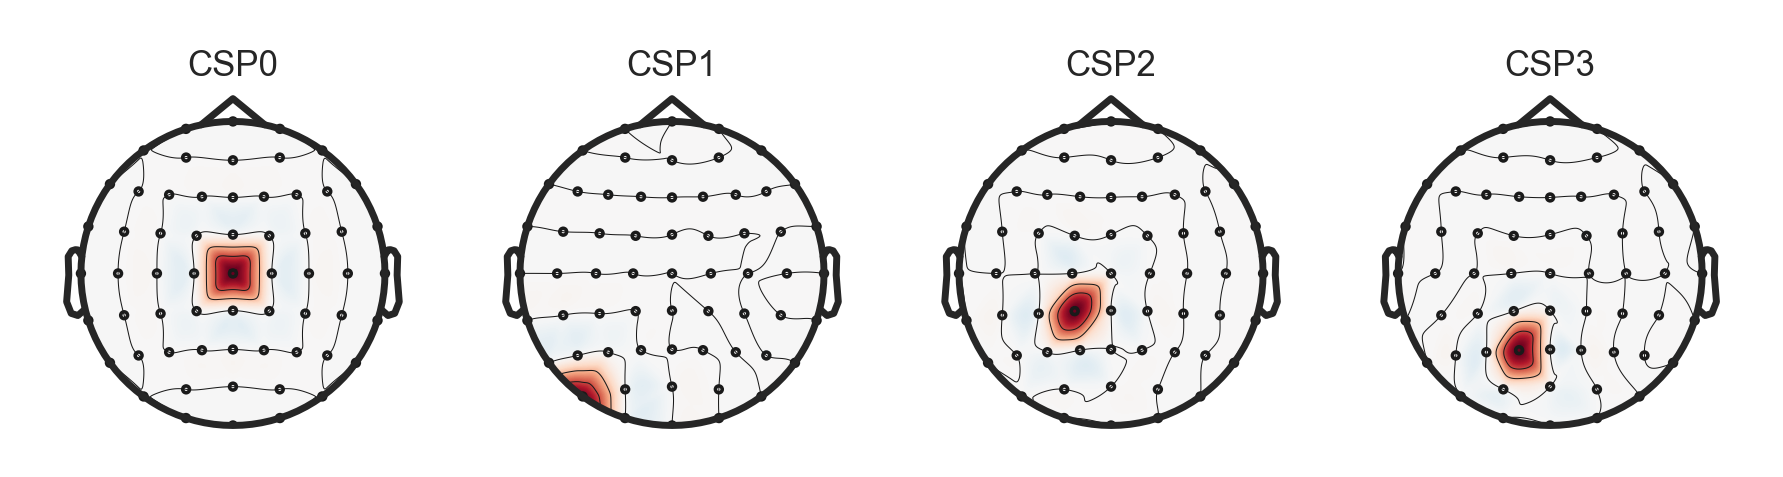

In [112]:
plot_csp(info, csp, data, epochs = dep, figname='dep_rewp_delta_csp')

CSP patterns diff between groups

In [154]:
data = rewp_depression_datasets[0]
labels = np.array(len(dep) * [1] +  len(ctrl_dep) * [0])
info = dep.iloc[0].epochs.copy().crop(tmin,tmax).pick('eeg').info

dep_data_ = data[:len(dep)]
dep_ctrl_data_ = data[len(dep):]

0.003125314519322548
0.000316641783406799
0.002707732457414352
0.0021259898435125905


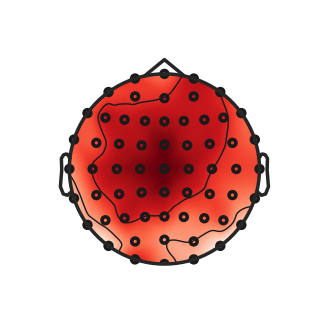

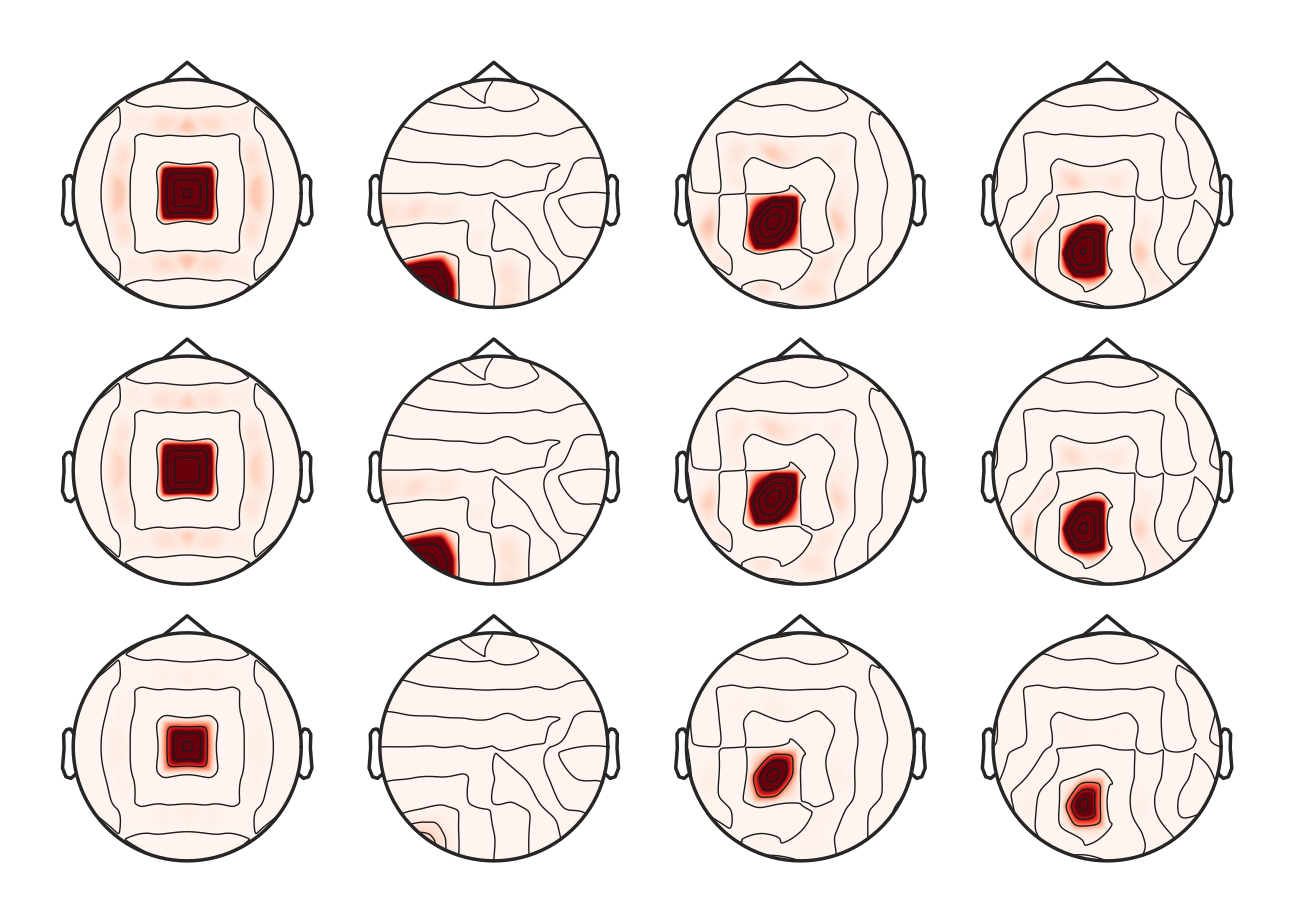

In [155]:
plot_differences_betten_groups_CSP_space(
    dep_rewp_delta_model_csp, 
    dep_data_, 
    dep_ctrl_data_, 
    labels, 
    info, 
    epochs=dep, 
    vlim=(0, 0.1),
    figname = 'dep_delta_diff'
)

- Depression RewP theta

In [113]:
data = rewp_depression_datasets[1]
labels = np.array(len(dep) * [1] +  len(ctrl_dep) * [0])
info = dep.iloc[0].epochs.copy().crop(tmin,tmax).pick('eeg').info
csp = dep_rewp_theta_model_csp

<Figure size 984.252x492.126 with 0 Axes>

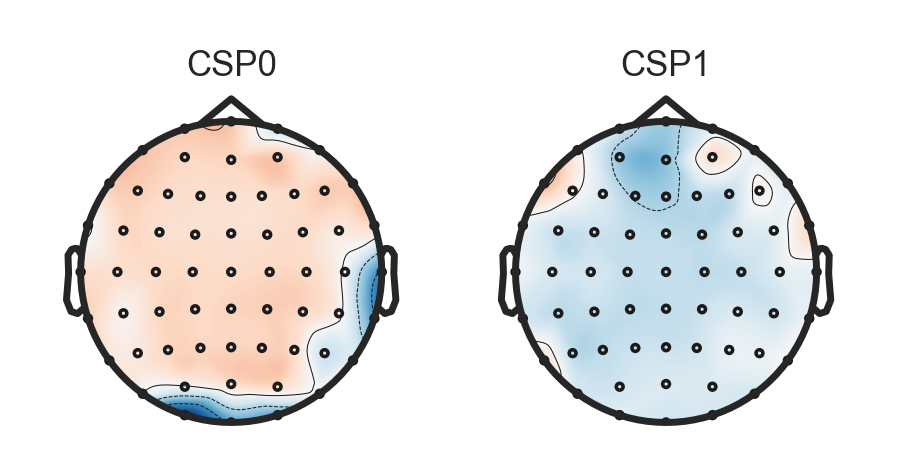

In [114]:
plot_csp(info, csp, data, epochs=dep, figname = 'dep_rewp_theta_csp')

CSP patterns diff between groups

In [157]:
data = rewp_depression_datasets[1]
labels = np.array(len(dep) * [1] +  len(ctrl_dep) * [0])
info = dep.iloc[0].epochs.copy().crop(tmin,tmax).pick('eeg').info
csp = dep_rewp_theta_model_csp

dep_data_ = data[:len(dep)]
dep_ctrl_data_ = data[len(dep):]

-0.0010270756414516823
-0.0011659974094359018


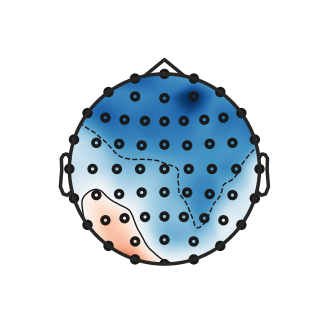

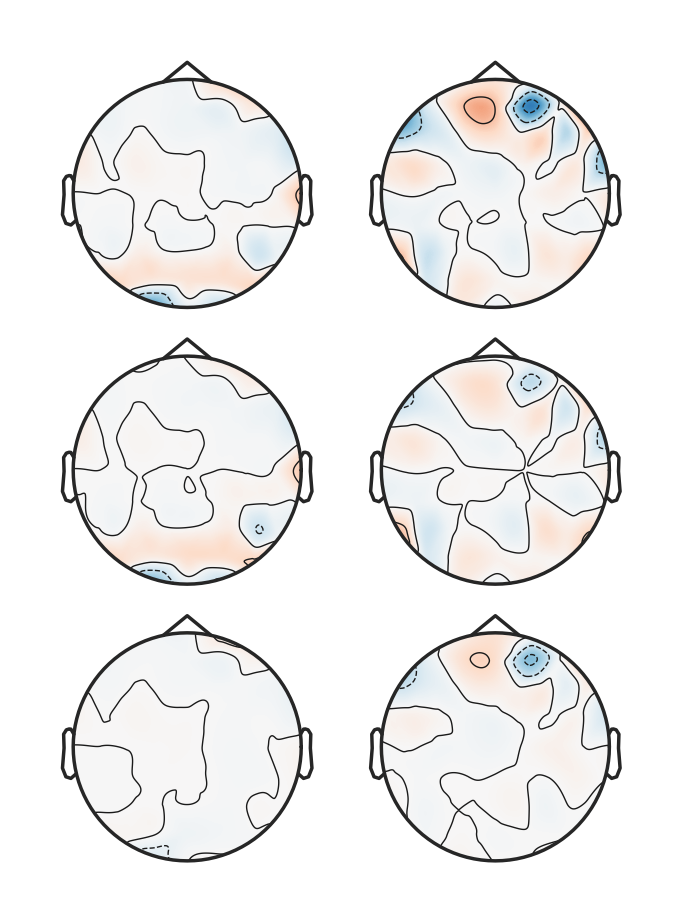

In [158]:
plot_differences_betten_groups_CSP_space(
    csp, dep_data_,
    dep_ctrl_data_, 
    labels,
    info, 
    epochs=dep, 
    vlim=(-0.2,0.2),
    figname='dep_theta_diff'
)

- Depression FRN delta

In [115]:
data = frn_depression_datasets[0]
labels = np.array(len(dep) * [1] +  len(ctrl_dep) * [0])
info = dep.iloc[0].epochs.copy().crop(tmin,tmax).pick('eeg').info
csp = dep_frn_delta_model_csp

<Figure size 984.252x492.126 with 0 Axes>

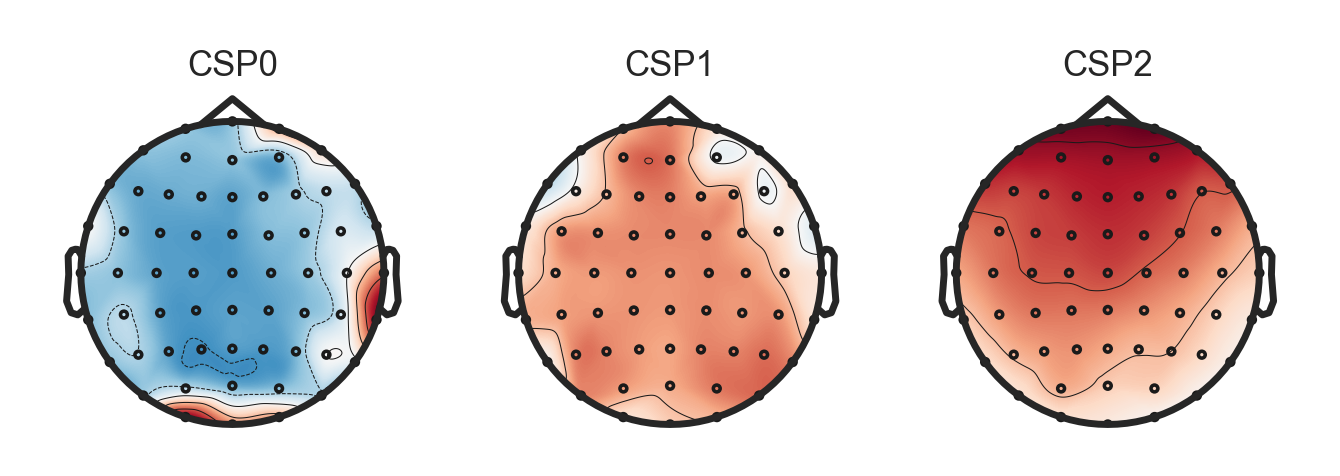

In [116]:
plot_csp(info, csp, data, epochs=dep, figname = 'dep_frn_delta_csp')

In [160]:
data = frn_depression_datasets[0]
labels = np.array(len(dep) * [1] +  len(ctrl_dep) * [0])
info = dep.iloc[0].epochs.copy().crop(tmin,tmax).pick('eeg').info
csp = dep_frn_delta_model_csp

dep_data_ = data[:len(dep)]
dep_ctrl_data_ = data[len(dep):]

0.0015449390897964762
-0.0023386871802399912
0.003547056574247542


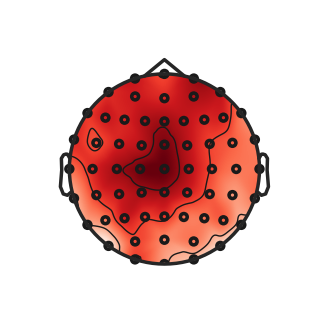

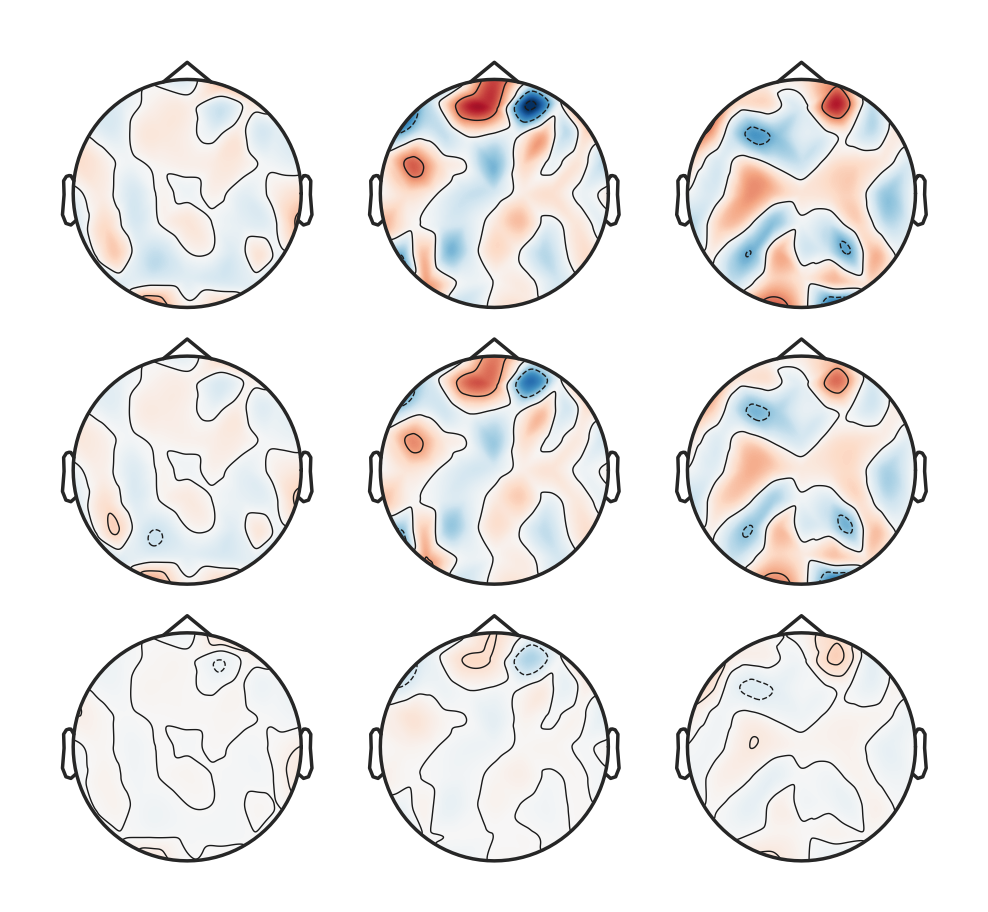

In [161]:
plot_differences_betten_groups_CSP_space(
    csp, 
    dep_data_, 
    dep_ctrl_data_, 
    labels, 
    info, 
    epochs=dep, 
    vlim=(-0.5,0.5),
    figname='dep_delta_frn_diff'
)

- Depression FRN theta

In [117]:
data = frn_depression_datasets[1]
labels = np.array(len(dep) * [1] +  len(ctrl_dep) * [0])
info = dep.iloc[0].epochs.copy().crop(tmin,tmax).pick('eeg').info
csp = dep_frn_theta_model_csp

<Figure size 984.252x492.126 with 0 Axes>

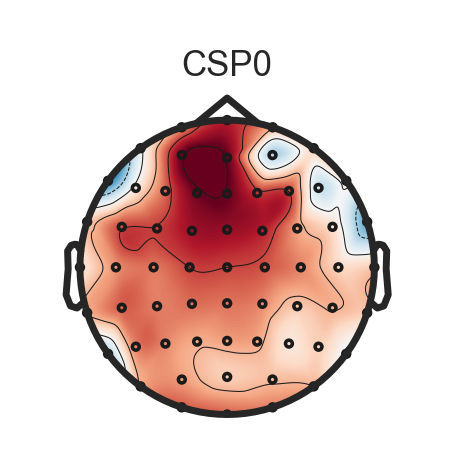

In [118]:
plot_csp(info, csp, data, epochs=dep,figname = 'dep_frn_theta_csp')

In [162]:
data = frn_depression_datasets[1]
labels = np.array(len(dep) * [1] +  len(ctrl_dep) * [0])
info = dep.iloc[0].epochs.copy().crop(tmin,tmax).pick('eeg').info
csp = dep_frn_theta_model_csp

dep_data_ = data[:len(dep)]
dep_ctrl_data_ = data[len(dep):]

0.0018955383246541805


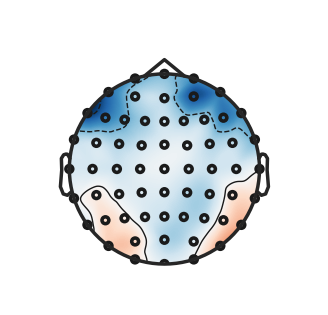

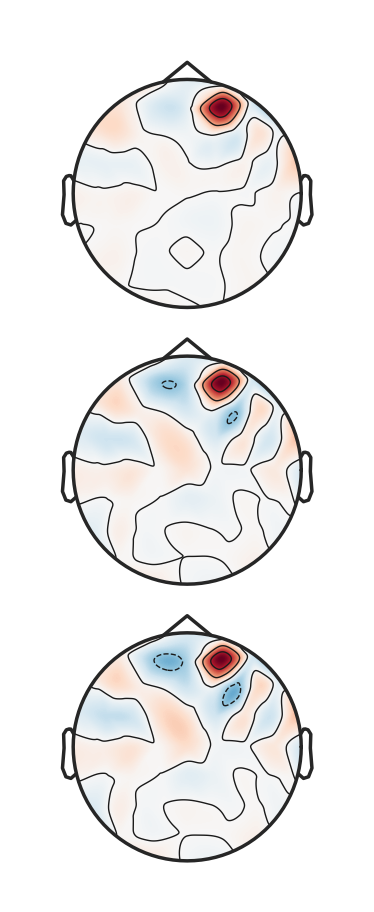

In [163]:
plot_differences_betten_groups_CSP_space(
    csp, 
    dep_data_, 
    dep_ctrl_data_, 
    labels,
    info, 
    epochs=dep, 
    figname = 
    'dep_theta_frn_diff'
)

- Anxiety RewP delta

In [119]:
data = rewp_anxiety_datasets[0]
labels = np.array(len(anx) * [1] +  len(ctrl_anx) * [0])
info = anx.iloc[0].epochs.copy().crop(tmin,tmax).pick('eeg').info
csp = anx_rewp_delta_model_csp

<Figure size 984.252x492.126 with 0 Axes>

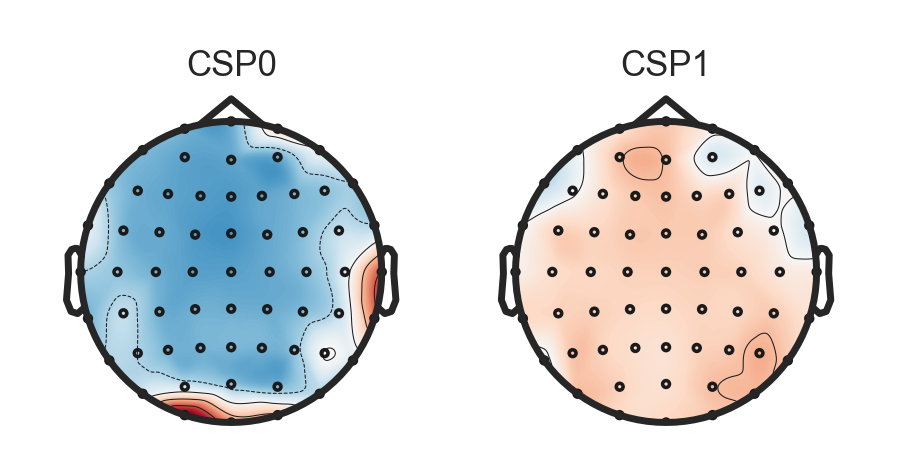

In [120]:
plot_csp(info, csp, data, epochs=anx, figname='anx_rewp_delta_csp')

In [166]:
data = rewp_anxiety_datasets[0]
labels = np.array(len(dep) * [1] +  len(ctrl_dep) * [0])
info = anx.iloc[0].epochs.copy().crop(tmin,tmax).pick('eeg').info
csp = anx_rewp_delta_model_csp

dep_data_ = data[:len(anx)]
dep_ctrl_data_ = data[len(anx):]

-0.0017106538611797036
0.001908124777811992


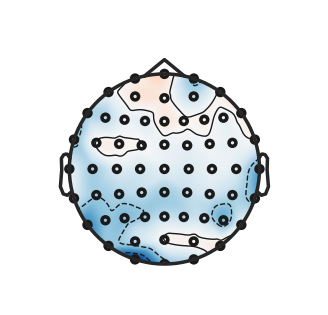

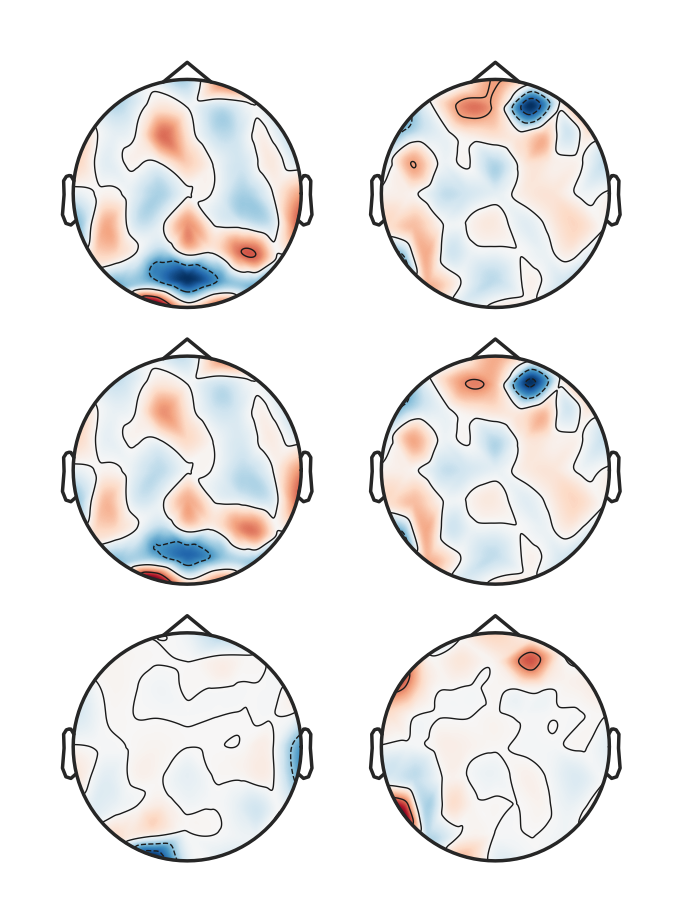

In [167]:
plot_differences_betten_groups_CSP_space(
    csp, 
    dep_data_, 
    dep_ctrl_data_, 
    labels, 
    info, 
    epochs=anx,
    figname='anx_delta_rewp_diff'
)

- Anxiety RewP theta

In [121]:
data = rewp_anxiety_datasets[1]
labels = np.array(len(anx) * [1] +  len(ctrl_anx) * [0])
info = anx.iloc[0].epochs.copy().crop(tmin,tmax).pick('eeg').info
csp = anx_rewp_theta_model_csp

<Figure size 984.252x492.126 with 0 Axes>

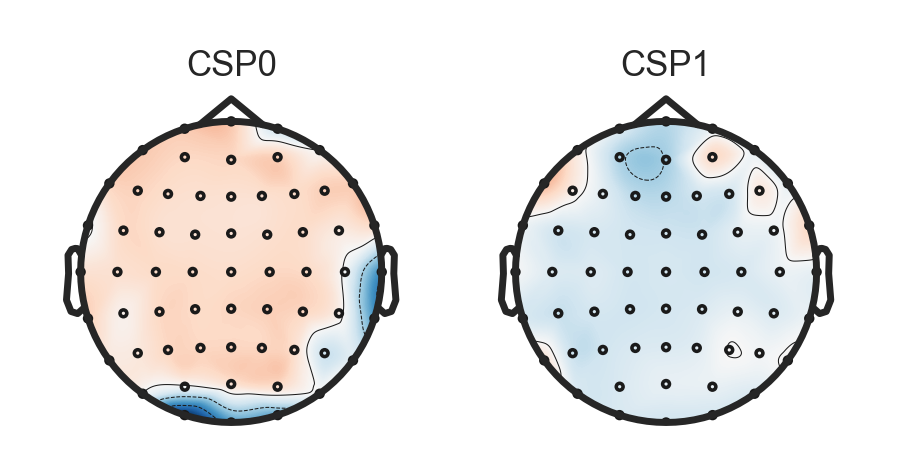

In [122]:
plot_csp(info, csp, data, epochs=anx, figname = 'anx_rewp_theta_csp')

In [168]:
data = rewp_anxiety_datasets[1]
labels = np.array(len(dep) * [1] +  len(ctrl_dep) * [0])
info = anx.iloc[0].epochs.copy().crop(tmin,tmax).pick('eeg').info
csp = anx_rewp_theta_model_csp

dep_data_ = data[:len(anx)]
dep_ctrl_data_ = data[len(anx):]

0.0014056237859342035
0.0012647689751694301


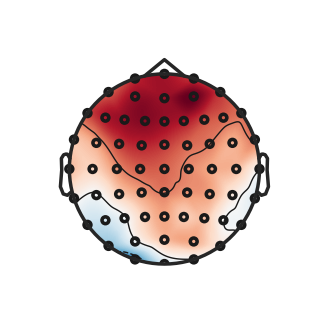

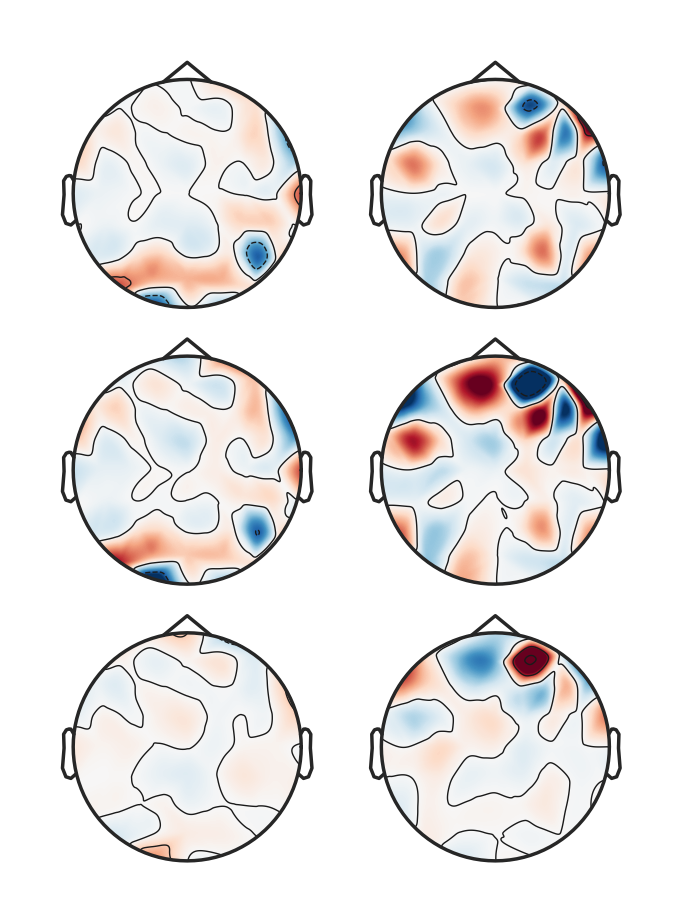

In [169]:
plot_differences_betten_groups_CSP_space(
    csp, 
    dep_data_, 
    dep_ctrl_data_, 
    labels, 
    info, 
    vlim=(-0.1,0.1),
    epochs=anx,
    figname='anx_theta_rewp_diff'
)

- Anxiety FRN delta

In [123]:
data = frn_anxiety_datasets[0]
labels = np.array(len(anx) * [1] +  len(ctrl_anx) * [0])
info = anx.iloc[0].epochs.copy().crop(tmin,tmax).pick('eeg').info
csp = anx_frn_delta_model_csp

<Figure size 984.252x492.126 with 0 Axes>

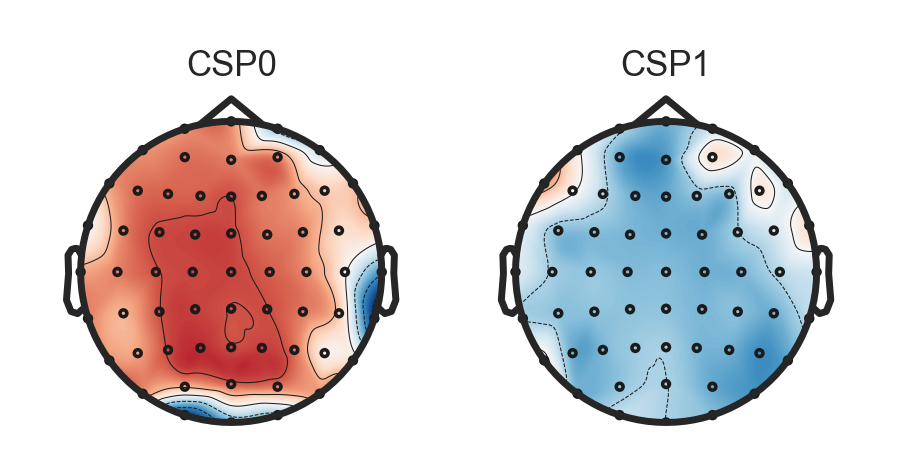

In [124]:
plot_csp(info, csp, data, epochs=anx, figname = 'anx_frn_delta_csp')

In [174]:
data = frn_anxiety_datasets[0]
labels = np.array(len(dep) * [1] +  len(ctrl_dep) * [0])
info = anx.iloc[0].epochs.copy().crop(tmin,tmax).pick('eeg').info
csp = anx_frn_delta_model_csp

dep_data_ = data[:len(anx)]
dep_ctrl_data_ = data[len(anx):]

0.001927683407399792
-0.0015666900395386425


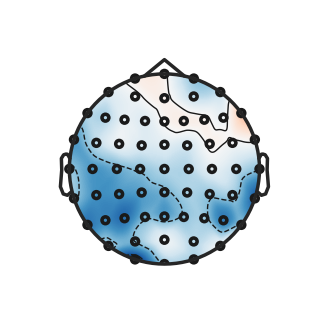

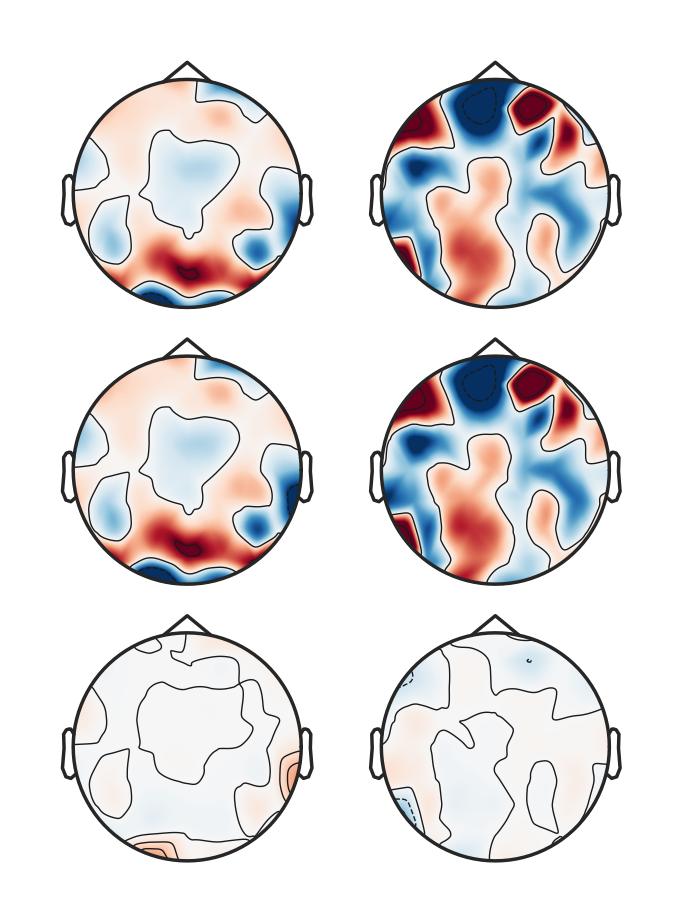

In [175]:
plot_differences_betten_groups_CSP_space(
    csp, 
    dep_data_, 
    dep_ctrl_data_, 
    labels, 
    info, 
    vlim=(-0.1, 0.1),
    epochs=anx,
    figname='anx_delta_frn_diff'
)

- Anxiety FRN theta

In [125]:
data = frn_anxiety_datasets[1]
labels = np.array(len(anx) * [1] +  len(ctrl_anx) * [0])
info = anx.iloc[0].epochs.copy().crop(tmin,tmax).pick('eeg').info
csp = anx_frn_theta_model_csp

<Figure size 984.252x492.126 with 0 Axes>

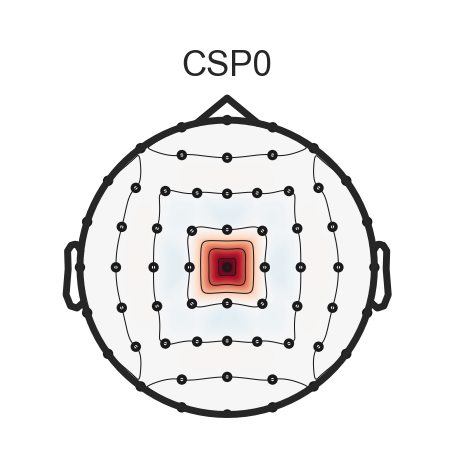

In [126]:
plot_csp(info, csp, data, epochs=anx, figname = 'anx_frn_theta_csp')

In [188]:
data = frn_anxiety_datasets[1]
labels = np.array(len(dep) * [1] +  len(ctrl_dep) * [0])
info = anx.iloc[0].epochs.copy().crop(tmin,tmax).pick('eeg').info
csp = anx_frn_theta_model_csp

dep_data_ = data[:len(anx)]
dep_ctrl_data_ = data[len(anx):]

0.00038927097955724764


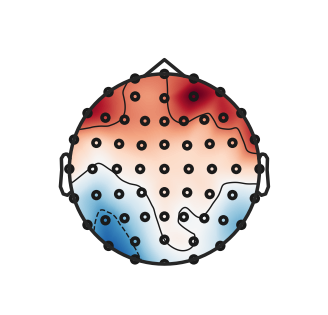

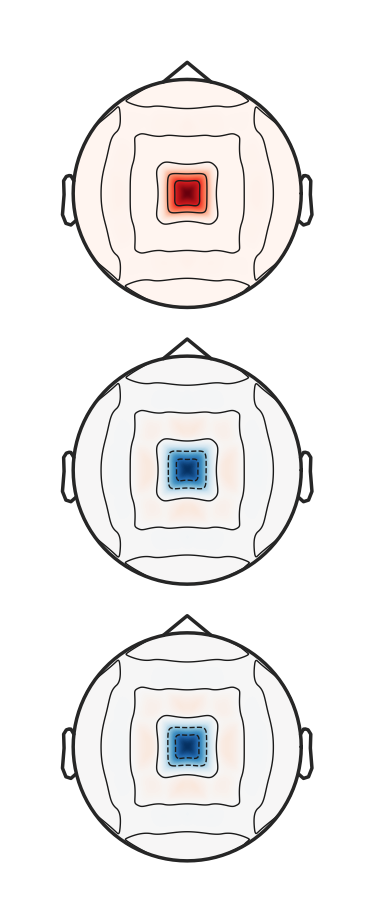

In [206]:
plot_differences_betten_groups_CSP_space(
    csp, 
    dep_data_, 
    dep_ctrl_data_, 
    labels, 
    info, 
    # vlim=(-0.1,0.1),
    epochs=anx,
    figname='anx_theta_frn_diff'
)

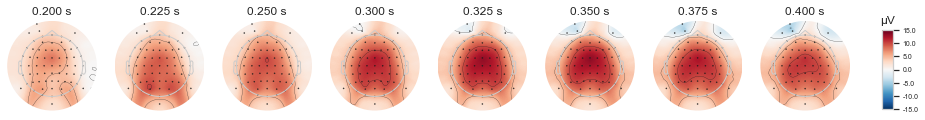

In [11]:
# f_good
fig = mne.viz.plot_evoked_topomap(
    evoked = evokeds[0],
    times = [0.2, 0.225, 0.25, 0.3, 0.325, 0.35, 0.375, 0.4],
    vlim = (15,-15)
)

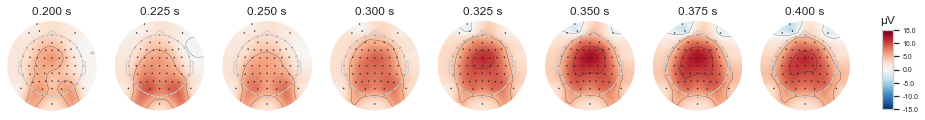

In [12]:
# f_bad
fig = mne.viz.plot_evoked_topomap(
    evoked = evokeds[1],
    times = [0.2, 0.225, 0.25, 0.3, 0.325, 0.35, 0.375, 0.4],
    vlim = (15,-15)
)

In [13]:
# diff
evokeds_diff_data = evokeds[0].get_data() - evokeds[1].get_data()
evoked_diff = mne.EvokedArray(evokeds_diff_data, info = evokeds[0].info, tmin = evokeds[0].tmin,)

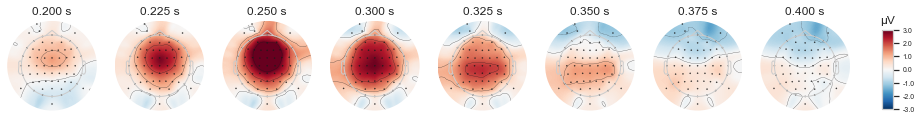

In [14]:
fig = mne.viz.plot_evoked_topomap(
    evoked = evoked_diff,
    times = [0.2, 0.225, 0.25, 0.3, 0.325, 0.35, 0.375, 0.4],
    vlim = (3,-3)
)

Need more than one channel to make topography for eeg. Disabling interactivity.


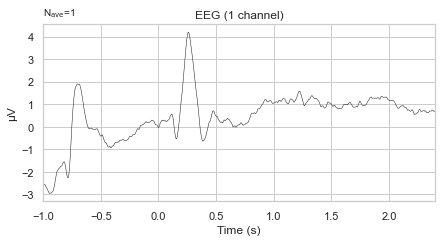

In [15]:
fig = evoked_diff.plot(picks=["FCz"])

## Visualize TFR

In [377]:
# Factor to down-sample the temporal dimension of the TFR computed by tfr_morlet.
decim = 1

# frequencies of interest in log distribution
freqs = np.linspace(0.2, 15, num=60)  
cycles = freqs / 0.8

# morelet parameters (number of cycles)
n_cycles = cycles

epochs_power = list()
tfr = list()

# perform morlet TF decomposition
tfr = tfr_morlet(evokeds, freqs, n_cycles=n_cycles,
                      decim=decim, average=True, return_itc=False, verbose=0, n_jobs=10)

# width=0.35
# fmin, fmax = freqs[[0, -1]]
# tfr = tfr_stockwell(evokeds, fmin=fmin, fmax=fmax, width=width)
# apply baseline
# tfr.apply_baseline(mode='mean', baseline=(-0.4, -0.1), verbose=0)

# tfr = tfr_multitaper(
#         evokeds[1],
#         freqs=freqs,
#         n_cycles=n_cycles,
#         time_bandwidth=2.3,
#         return_itc=False,
# )
    
# Crop in time to keep only what is between 0 and 500 ms
# tfr.crop(0, 0.5)

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done  68 out of  68 | elapsed:    0.2s finished


[<Figure size 720x504 with 2 Axes>]

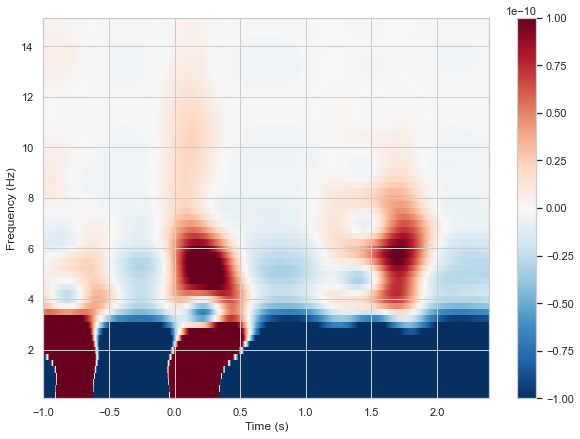

In [378]:
tfr.plot(
    ['FCz'],
    baseline=(-0.9, 0), 
    mode="mean", 
    show=False, 
    colorbar=True,
    vmin=-1e-10,
    vmax=1e-10
)

# morlet cycles freq / 0.8

[<Figure size 720x504 with 2 Axes>]

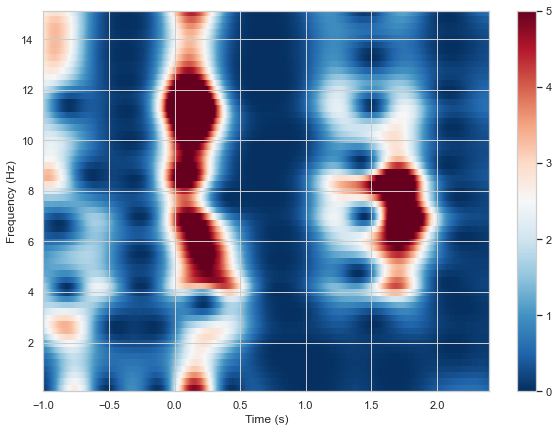

In [379]:
tfr.plot(
    ['FCz'],
    baseline=(-0.9, 0), 
    mode="ratio", 
    show=False, 
    colorbar=True,
    vmin=-0,
    vmax=5
)
# morlet 0.8

Applying baseline correction (mode: mean)


[<Figure size 720x504 with 2 Axes>]

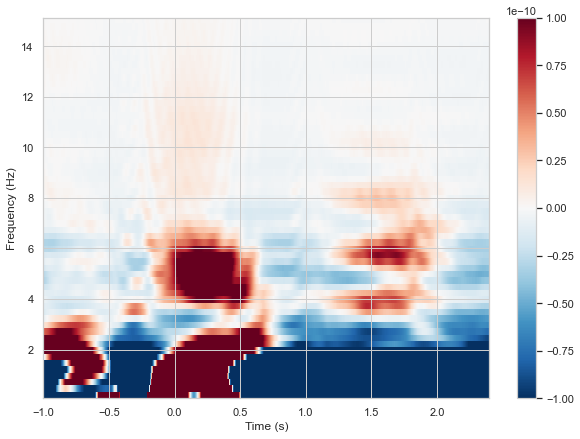

In [316]:
tfr.plot(
    ['FCz'],
    baseline=(-0.9, 0), 
    mode="mean", 
    show=False, 
    colorbar=True,
    vmin=-1e-10,
    vmax=1e-10,
    # vmin=-1,
    # vmax=5,
)
# multitaper

[<Figure size 720x504 with 2 Axes>]

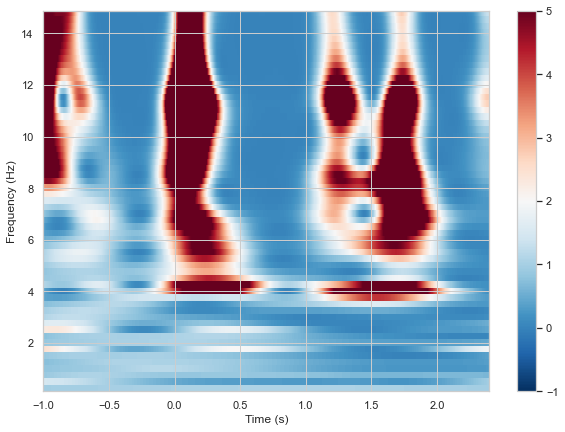

In [375]:
tfr.plot(
    ['FCz'],
    baseline=(-0.9, -0.1), 
    mode="ratio", 
    show=False, 
    colorbar=True,
    # vmin=-1e-13,
    # vmax=1e-13,
    vmin=-1,
    vmax=5,
)
# stockwell 0.35

[<Figure size 720x504 with 2 Axes>]

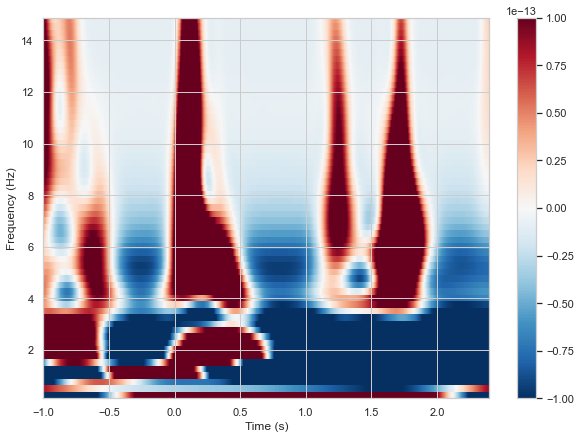

In [371]:
tfr.plot(
    ['FCz'],
    baseline=(-0.9, 0), 
    mode="mean", 
    show=False, 
    colorbar=True,
    vmin=-1e-13,
    vmax=1e-13,
)
# stockwell window 0.2

Applying baseline correction (mode: zlogratio)


[<Figure size 720x504 with 2 Axes>]

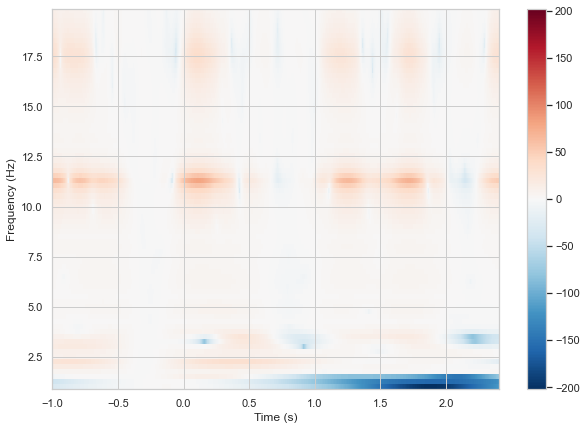

In [186]:
tfr.plot(
    ['FCz'],
    baseline=(-0.4, -0.2), 
    mode="zlogratio", 
    show=False, 
    colorbar=True,
    # vmin=-1e1,
    # vmax=1e1
)

## Visualize depressed vs control brain activity

In [4]:
freq_ranges = [(0.2,3), (4.0,7.5)]

### Delta

In [385]:
%%capture

data_df['delta'] = data_df['epochs'].apply(lambda x: x.copy().filter(
    None, 
    freq_ranges[0][1], 
    fir_design='firwin', 
    skip_by_annotation='edge',
    h_trans_bandwidth = 'auto',
))

In [386]:
data_df.to_pickle("data/sonata_data/freq.pkl")

In [7]:
depression_epochs = mne.concatenate_epochs(dep['delta'].to_list())
depression_ctr_epochs = mne.concatenate_epochs(ctrl_dep['delta'].to_list())

/tmp/ipykernel_21929/2216668141.py:1: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  depression_epochs = mne.concatenate_epochs(dep['delta'].to_list())


Not setting metadata
15368 matching events found
No baseline correction applied


/tmp/ipykernel_21929/2216668141.py:2: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  depression_ctr_epochs = mne.concatenate_epochs(ctrl_dep['delta'].to_list())


Not setting metadata
14688 matching events found
No baseline correction applied


In [13]:
evokeds_dep = [depression_epochs[name].average().copy().crop(tmin=-0.2, tmax=1.0) for name in ('f_good', 'f_bad')]
evokeds_dep_ctr = [depression_ctr_epochs[name].average().copy().crop(tmin=-0.2, tmax=1.0) for name in ('f_good', 'f_bad')]

evokeds = {
    'RewP DEP': evokeds_dep[0],
    'RewP CTR': evokeds_dep_ctr[0],
    'FRN DEP' : evokeds_dep[1],
    'FRN CTR' : evokeds_dep_ctr[1],
}

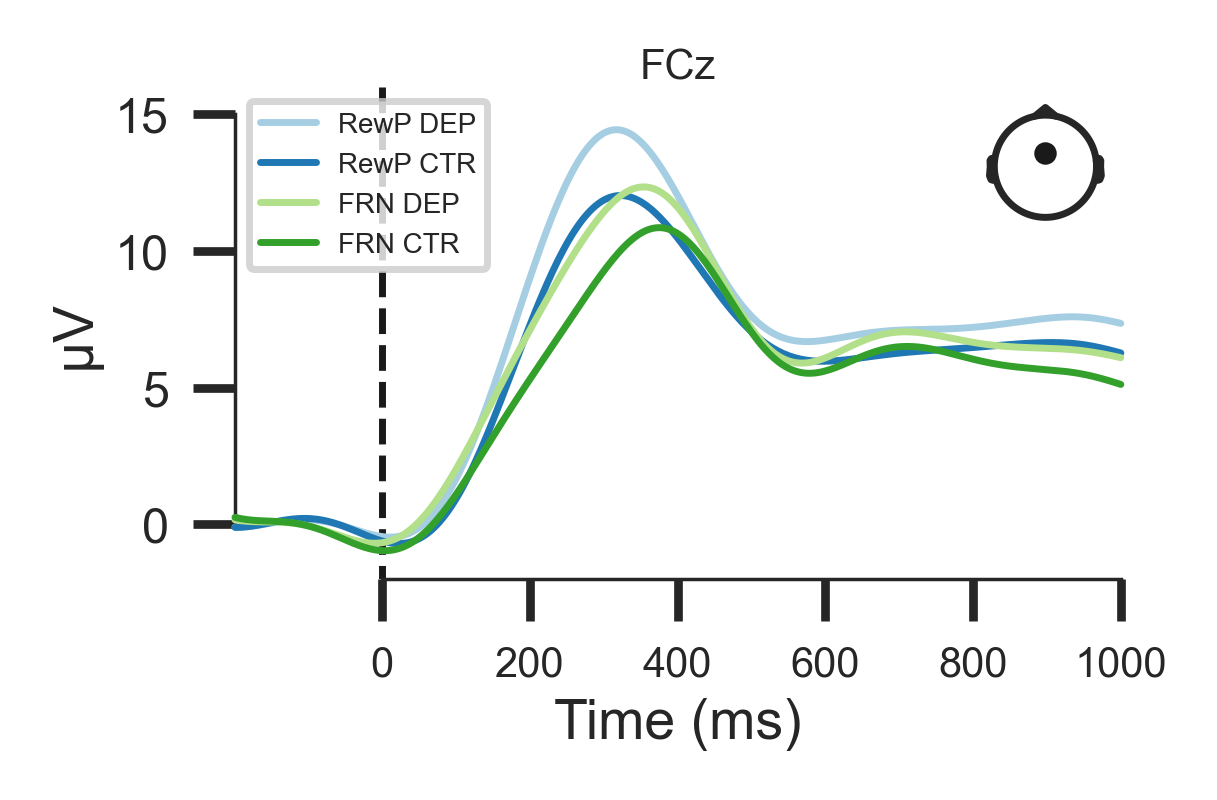

In [21]:
cm = 1/2.54
dpi = 500

plt.rc('font', size=4)
sns.set_style("ticks")


plt.rcParams['figure.dpi'] = dpi
# plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['ytick.labelsize'] = 7
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['axes.labelsize'] = 8
plt.rcParams["axes.edgecolor"] = ".15"
plt.rcParams["axes.linewidth"]  = 0.5
plt.rcParams['lines.linewidth'] = 1

plt.rcParams['axes.spines.bottom']= True
plt.rcParams['axes.spines.left']= True
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True

plt.rcParams['axes.titlesize'] = 6
plt.rcParams['figure.frameon'] = True
plt.rc('legend',fontsize=4)

plt.rcParams['axes.titlepad'] = 0.2
plt.rcParams['axes.labelpad'] = 2
plt.rcParams['axes.titlepad'] = 0.2



sns.set_palette('Paired')

picks = ["FCz"]

# fig = plt.figure()
# ax = fig.add_axes([0, 0, 0.78, 0.78])

fig = plt.figure(figsize=(4.5*cm, 2.5*cm))

ax = fig.add_axes([0,0,1,1], zorder=-1)
# topo_rewP_axis = fig.add_axes([0.76,0.67,0.32,0.32], zorder=1000)
# topo_FRN_axis = fig.add_axes([0.76,0.02,0.32,0.32], zorder=10000)


# rewp_fig, rewP_cont = mne.viz.plot_topomap(
#     rewp_delta_contrast.reshape(-1), 
#     evokeds_dep[0].info, 
#     show=False, 
#     res=1000, 
#     sensors=False,
#     axes=topo_rewP_axis
# )
# plt.setp(rewP_cont.collections , linewidth=0.5)
# plt.setp(topo_rewP_axis.lines , linewidth=0.5)


# frn_fig, frn_cont = mne.viz.plot_topomap(
#     frn_delta_contrast.reshape(-1), 
#     evokeds_dep[0].info, 
#     show=False, 
#     res=1000, 
#     sensors=False,
#     axes=topo_FRN_axis
# )
# plt.setp(frn_cont.collections , linewidth=0.5)
# plt.setp(topo_FRN_axis.lines , linewidth=0.5)



a = mne.viz.plot_compare_evokeds(
    evokeds, 
    picks=picks, 
    ci=0.95, 
    ylim=dict(eeg=[-2, 16]),
    axes=ax,
    time_unit='ms',
)


# fig.savefig(f'data/delta_dep', bbox_inches='tight', pad_inches=0.01)

In [22]:
depression_epochs = mne.concatenate_epochs(anx['delta'].to_list())
depression_ctr_epochs = mne.concatenate_epochs(ctrl_anx['delta'].to_list())

/tmp/ipykernel_21929/1072237204.py:1: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  depression_epochs = mne.concatenate_epochs(anx['delta'].to_list())


Not setting metadata
14688 matching events found
No baseline correction applied


/tmp/ipykernel_21929/1072237204.py:2: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  depression_ctr_epochs = mne.concatenate_epochs(ctrl_anx['delta'].to_list())


Not setting metadata
13523 matching events found
No baseline correction applied


In [23]:
evokeds_dep = [depression_epochs[name].average().copy().crop(tmin=-0.2, tmax=1.0) for name in ('f_good', 'f_bad')]
evokeds_dep_ctr = [depression_ctr_epochs[name].average().copy().crop(tmin=-0.2, tmax=1.0) for name in ('f_good', 'f_bad')]

evokeds = {
    'RewP DEP': evokeds_dep[0],
    'RewP CTR': evokeds_dep_ctr[0],
    'FRN DEP' : evokeds_dep[1],
    'FRN CTR' : evokeds_dep_ctr[1],
}

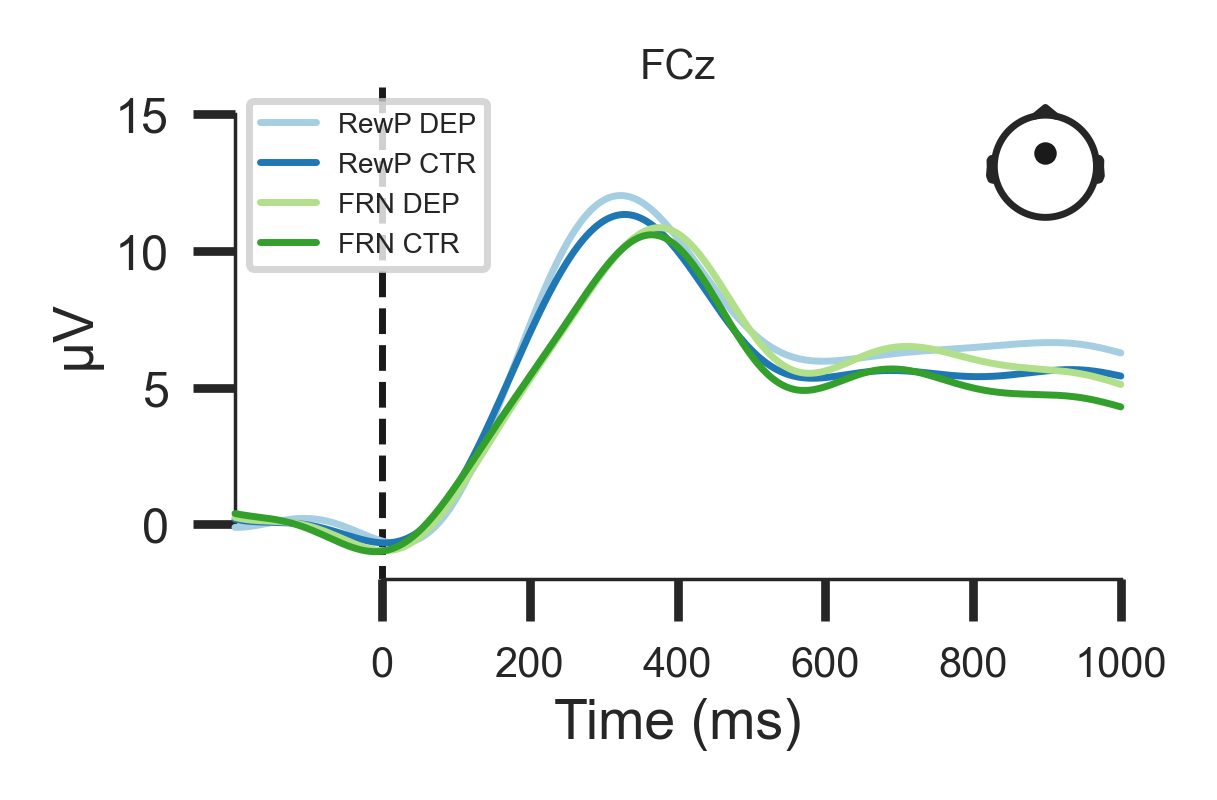

In [25]:
cm = 1/2.54
dpi = 500

plt.rc('font', size=4)
sns.set_style("ticks")


plt.rcParams['figure.dpi'] = dpi
# plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['ytick.labelsize'] = 7
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['axes.labelsize'] = 8
plt.rcParams["axes.edgecolor"] = ".15"
plt.rcParams["axes.linewidth"]  = 0.5
plt.rcParams['lines.linewidth'] = 1

plt.rcParams['axes.spines.bottom']= True
plt.rcParams['axes.spines.left']= True
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True

plt.rcParams['axes.titlesize'] = 6
plt.rcParams['figure.frameon'] = True
plt.rc('legend',fontsize=4)

plt.rcParams['axes.titlepad'] = 0.2
plt.rcParams['axes.labelpad'] = 2
plt.rcParams['axes.titlepad'] = 0.2



sns.set_palette('Paired')

picks = ["FCz"]

# fig = plt.figure()
# ax = fig.add_axes([0, 0, 0.78, 0.78])

fig = plt.figure(figsize=(4.5*cm, 2.5*cm))

ax = fig.add_axes([0,0,1,1], zorder=-1)
# topo_rewP_axis = fig.add_axes([0.76,0.67,0.32,0.32], zorder=1000)
# topo_FRN_axis = fig.add_axes([0.76,0.02,0.32,0.32], zorder=10000)


# rewp_fig, rewP_cont = mne.viz.plot_topomap(
#     rewp_delta_contrast.reshape(-1), 
#     evokeds_dep[0].info, 
#     show=False, 
#     res=1000, 
#     sensors=False,
#     axes=topo_rewP_axis
# )
# plt.setp(rewP_cont.collections , linewidth=0.5)
# plt.setp(topo_rewP_axis.lines , linewidth=0.5)


# frn_fig, frn_cont = mne.viz.plot_topomap(
#     frn_delta_contrast.reshape(-1), 
#     evokeds_dep[0].info, 
#     show=False, 
#     res=1000, 
#     sensors=False,
#     axes=topo_FRN_axis
# )
# plt.setp(frn_cont.collections , linewidth=0.5)
# plt.setp(topo_FRN_axis.lines , linewidth=0.5)



a = mne.viz.plot_compare_evokeds(
    evokeds, 
    picks=picks, 
    ci=0.95, 
    ylim=dict(eeg=[-2, 16]),
    axes=ax,
    time_unit='ms',
)


# fig.savefig(f'data/delta_anx', bbox_inches='tight', pad_inches=0.01)

### Theta

In [5]:
%%capture

data_df['theta'] = data_df['epochs'].apply(lambda x: x.copy().filter(
    freq_ranges[1][0], 
    freq_ranges[1][1], 
    fir_design='firwin', 
    skip_by_annotation='edge',
    h_trans_bandwidth = 'auto',
))

In [7]:
data_df.head()

id                                             epochs Demo_kod  BDI  \
0  000  <Epochs |  212 events (all good), -1 - 2.39844...      000    6   
1  012  <Epochs |  181 events (all good), -1 - 2.39844...      012   45   
2  014  <Epochs |  219 events (all good), -1 - 2.39844...      014   17   
3  037  <Epochs |  223 events (all good), -1 - 2.39844...      037   10   
4  041  <Epochs |  207 events (all good), -1 - 2.39844...      041    8   

   BDI_cognitive  BDI_affective  BDI_affect_cog  BDI_somatic  STAI  \
0           0.17           0.67            0.83         0.50    40   
1           2.33           2.00            4.33         1.67    50   
2           1.00           0.33            1.33         0.83    58   
3           0.17           1.67            1.83         0.33    51   
4           0.33           0.33            0.67         0.17    48   

                                               delta  \
0  <Epochs |  212 events (all good), -1 - 2.39844...   
1  <Epochs |  181 events (all good), -1 - 2.39844...   
2  <Epochs |  219 events (all good), -1 - 2.39844...   
3  <Epochs |  223 events (all good), -1 - 2.39844...   
4  <Epochs |  207 events (all good), -1 - 2.39844...   

                                               theta  
0  <Epochs |  212 events (all good), -1 - 2.39844...  
1  <Epochs |  181 events (all good), -1 - 2.39844...  
2  <Epochs |  219 events (all good), -1 - 2.39844...  
3  <Epochs |  223 events (all good), -1 - 2.39844...  
4  <Epochs |  207 events (all good), -1 - 2.39844...

In [8]:
data_df.to_pickle("data/sonata_data/freq2.pkl")

In [16]:
depression_epochs = mne.concatenate_epochs(dep['theta'].to_list())
depression_ctr_epochs = mne.concatenate_epochs(ctrl_dep['theta'].to_list())

/tmp/ipykernel_14101/3861393698.py:1: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  depression_epochs = mne.concatenate_epochs(dep['theta'].to_list())


Not setting metadata
15368 matching events found
No baseline correction applied


/tmp/ipykernel_14101/3861393698.py:2: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  depression_ctr_epochs = mne.concatenate_epochs(ctrl_dep['theta'].to_list())


Not setting metadata
14688 matching events found
No baseline correction applied


In [17]:
evokeds_dep = [depression_epochs[name].average().crop(tmin=-0.2, tmax=1.0) for name in ('f_good', 'f_bad')]
evokeds_dep_ctr = [depression_ctr_epochs[name].average().crop(tmin=-0.2, tmax=1.0) for name in ('f_good', 'f_bad')]

evokeds = {
    'RewP DEP': evokeds_dep[0],
    'RewP CTR': evokeds_dep_ctr[0],
    'FRN DEP' : evokeds_dep[1],
    'FRN CTR' : evokeds_dep_ctr[1],
}

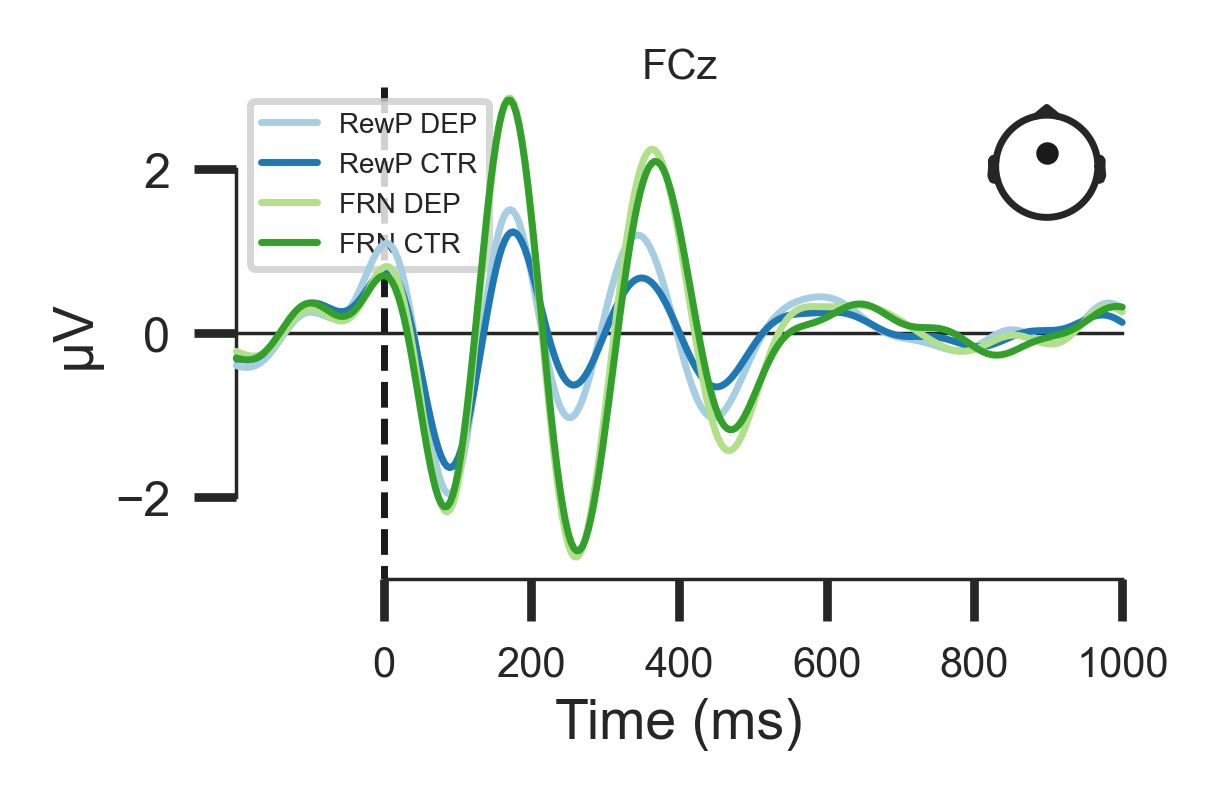

In [18]:
cm = 1/2.54
dpi = 500

plt.rc('font', size=4)
sns.set_style("ticks")


plt.rcParams['figure.dpi'] = dpi
# plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['ytick.labelsize'] = 7
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['axes.labelsize'] = 8
plt.rcParams["axes.edgecolor"] = ".15"
plt.rcParams["axes.linewidth"]  = 0.5
plt.rcParams['lines.linewidth'] = 1

plt.rcParams['axes.spines.bottom']= True
plt.rcParams['axes.spines.left']= True
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True

plt.rcParams['axes.titlesize'] = 6
plt.rcParams['figure.frameon'] = True
plt.rc('legend',fontsize=4)

plt.rcParams['axes.titlepad'] = 0.2
plt.rcParams['axes.labelpad'] = 2
plt.rcParams['axes.titlepad'] = 0.2



sns.set_palette('Paired')

picks = ["FCz"]

# fig = plt.figure()
# ax = fig.add_axes([0, 0, 0.78, 0.78])

fig = plt.figure(figsize=(4.5*cm, 2.5*cm))

ax = fig.add_axes([0,0,1,1], zorder=-1)
# topo_rewP_axis = fig.add_axes([0.76,0.67,0.32,0.32], zorder=1000)
# topo_FRN_axis = fig.add_axes([0.76,0.02,0.32,0.32], zorder=10000)


# rewp_fig, rewP_cont = mne.viz.plot_topomap(
#     rewp_delta_contrast.reshape(-1), 
#     evokeds_dep[0].info, 
#     show=False, 
#     res=1000, 
#     sensors=False,
#     axes=topo_rewP_axis
# )
# plt.setp(rewP_cont.collections , linewidth=0.5)
# plt.setp(topo_rewP_axis.lines , linewidth=0.5)


# frn_fig, frn_cont = mne.viz.plot_topomap(
#     frn_delta_contrast.reshape(-1), 
#     evokeds_dep[0].info, 
#     show=False, 
#     res=1000, 
#     sensors=False,
#     axes=topo_FRN_axis
# )
# plt.setp(frn_cont.collections , linewidth=0.5)
# plt.setp(topo_FRN_axis.lines , linewidth=0.5)



a = mne.viz.plot_compare_evokeds(
    evokeds, 
    picks=picks, 
    ci=0.95, 
    ylim=dict(eeg=[-3, 3]),
    axes=ax,
    time_unit='ms',
)


# fig.savefig(f'data/theta_dep', bbox_inches='tight', pad_inches=0.01)

In [28]:
depression_epochs = mne.concatenate_epochs(anx['theta'].to_list())
depression_ctr_epochs = mne.concatenate_epochs(ctrl_anx['theta'].to_list())

/tmp/ipykernel_14101/1184506707.py:1: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  depression_epochs = mne.concatenate_epochs(anx['theta'].to_list())


Not setting metadata
14688 matching events found
No baseline correction applied


/tmp/ipykernel_14101/1184506707.py:2: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  depression_ctr_epochs = mne.concatenate_epochs(ctrl_anx['theta'].to_list())


Not setting metadata
13523 matching events found
No baseline correction applied


In [29]:
evokeds_dep = [depression_epochs[name].average().crop(tmin=-0.2, tmax=1.0) for name in ('f_good', 'f_bad')]
evokeds_dep_ctr = [depression_ctr_epochs[name].average().crop(tmin=-0.2, tmax=1.0) for name in ('f_good', 'f_bad')]

evokeds = {
    'RewP DEP': evokeds_dep[0],
    'RewP CTR': evokeds_dep_ctr[0],
    'FRN DEP' : evokeds_dep[1],
    'FRN CTR' : evokeds_dep_ctr[1],
}

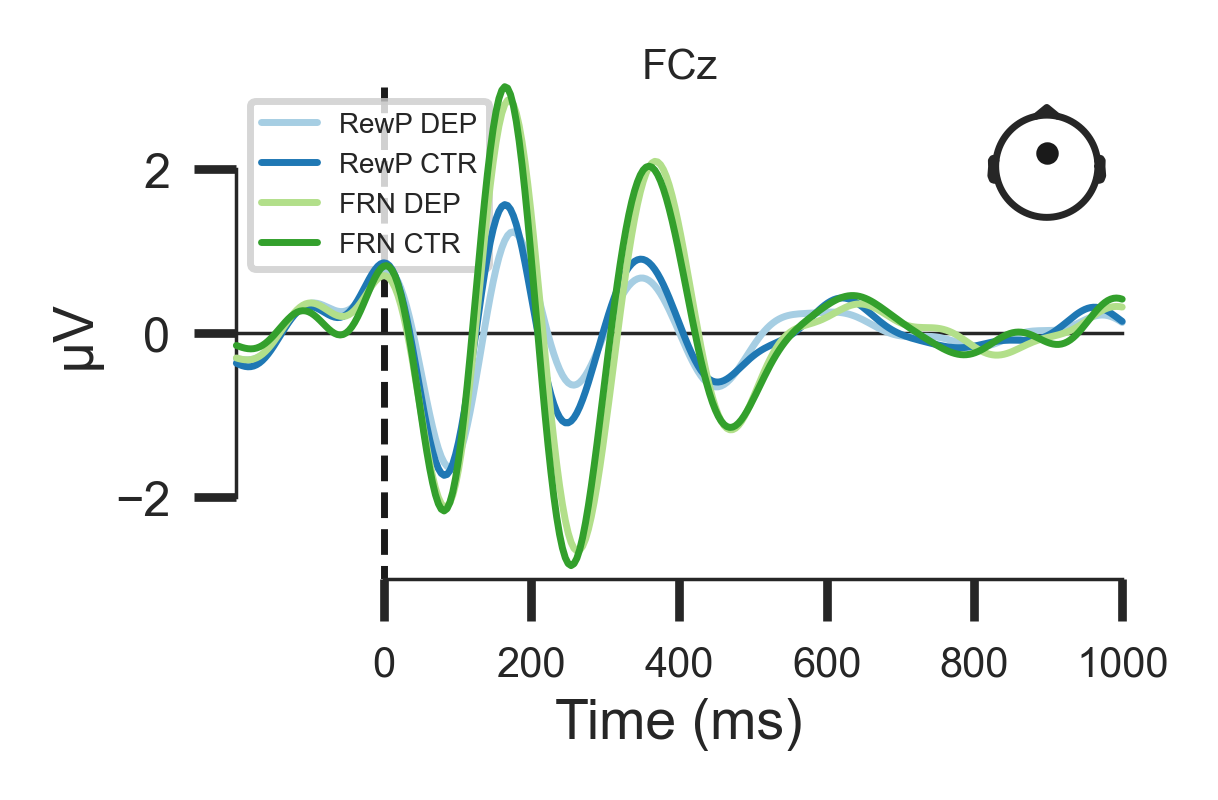

In [30]:
cm = 1/2.54
dpi = 500

plt.rc('font', size=4)
sns.set_style("ticks")


plt.rcParams['figure.dpi'] = dpi
# plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['ytick.labelsize'] = 7
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['axes.labelsize'] = 8
plt.rcParams["axes.edgecolor"] = ".15"
plt.rcParams["axes.linewidth"]  = 0.5
plt.rcParams['lines.linewidth'] = 1

plt.rcParams['axes.spines.bottom']= True
plt.rcParams['axes.spines.left']= True
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True

plt.rcParams['axes.titlesize'] = 6
plt.rcParams['figure.frameon'] = True
plt.rc('legend',fontsize=4)

plt.rcParams['axes.titlepad'] = 0.2
plt.rcParams['axes.labelpad'] = 2
plt.rcParams['axes.titlepad'] = 0.2



sns.set_palette('Paired')

picks = ["FCz"]

# fig = plt.figure()
# ax = fig.add_axes([0, 0, 0.78, 0.78])

fig = plt.figure(figsize=(4.5*cm, 2.5*cm))

ax = fig.add_axes([0,0,1,1], zorder=-1)
# topo_rewP_axis = fig.add_axes([0.76,0.67,0.32,0.32], zorder=1000)
# topo_FRN_axis = fig.add_axes([0.76,0.02,0.32,0.32], zorder=10000)


# rewp_fig, rewP_cont = mne.viz.plot_topomap(
#     rewp_delta_contrast.reshape(-1), 
#     evokeds_dep[0].info, 
#     show=False, 
#     res=1000, 
#     sensors=False,
#     axes=topo_rewP_axis
# )
# plt.setp(rewP_cont.collections , linewidth=0.5)
# plt.setp(topo_rewP_axis.lines , linewidth=0.5)


# frn_fig, frn_cont = mne.viz.plot_topomap(
#     frn_delta_contrast.reshape(-1), 
#     evokeds_dep[0].info, 
#     show=False, 
#     res=1000, 
#     sensors=False,
#     axes=topo_FRN_axis
# )
# plt.setp(frn_cont.collections , linewidth=0.5)
# plt.setp(topo_FRN_axis.lines , linewidth=0.5)



a = mne.viz.plot_compare_evokeds(
    evokeds, 
    picks=picks, 
    ci=0.95, 
    ylim=dict(eeg=[-3, 3]),
    axes=ax,
    time_unit='ms',
)


# fig.savefig(f'data/theta_anx', bbox_inches='tight', pad_inches=0.01)

## ERPs

- DEP

In [19]:
depression_epochs = mne.concatenate_epochs(dep['epochs'].to_list())
depression_ctr_epochs = mne.concatenate_epochs(ctrl_dep['epochs'].to_list())

/tmp/ipykernel_14101/4046670063.py:1: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  depression_epochs = mne.concatenate_epochs(dep['epochs'].to_list())


Not setting metadata
15368 matching events found
No baseline correction applied


/tmp/ipykernel_14101/4046670063.py:2: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  depression_ctr_epochs = mne.concatenate_epochs(ctrl_dep['epochs'].to_list())


Not setting metadata
14688 matching events found
No baseline correction applied


In [20]:
evokeds_dep = [depression_epochs[name].average().copy().crop(tmin=-0.2, tmax=1.0) for name in ('f_good', 'f_bad')]
evokeds_dep_ctr = [depression_ctr_epochs[name].average().copy().crop(tmin=-0.2, tmax=1.0) for name in ('f_good', 'f_bad')]

evokeds = {
    'RewP DEP': evokeds_dep[0],
    'RewP CTR': evokeds_dep_ctr[0],
    'FRN DEP' : evokeds_dep[1],
    'FRN CTR' : evokeds_dep_ctr[1],
}

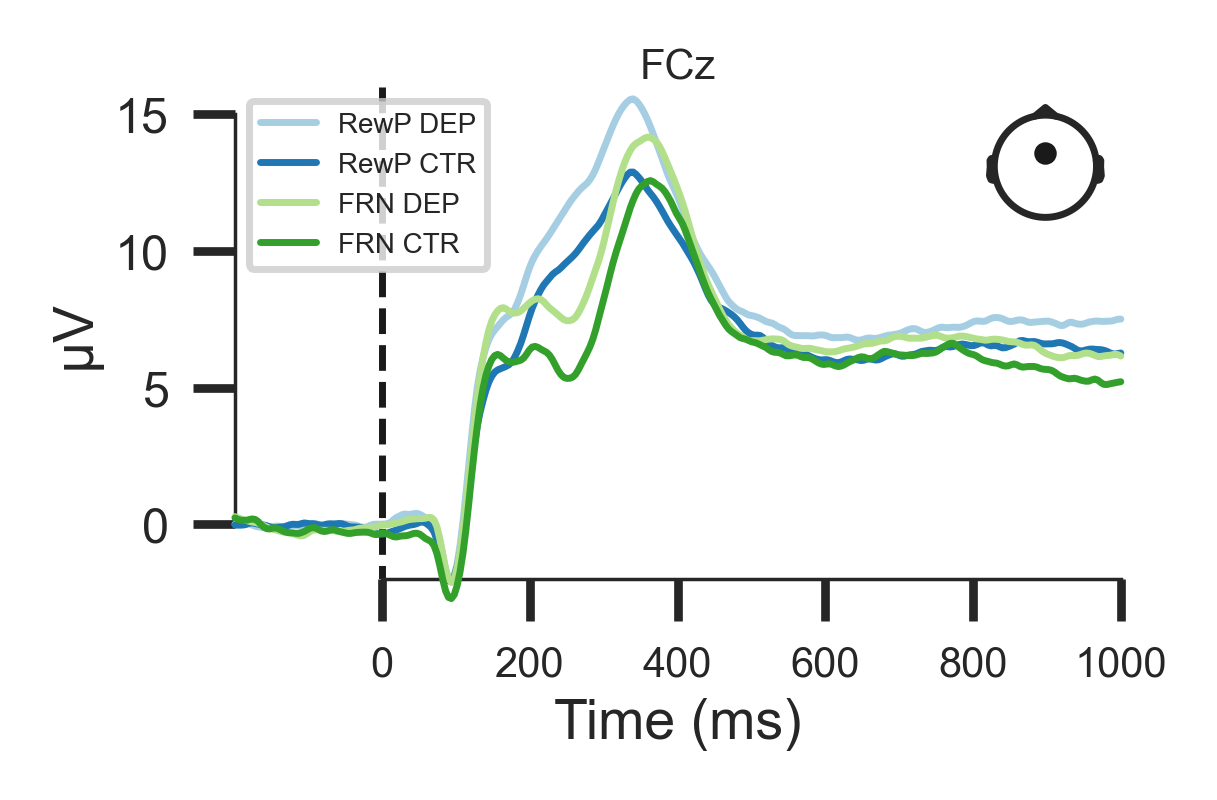

In [21]:
cm = 1/2.54
dpi = 500

plt.rc('font', size=4)
sns.set_style("ticks")


plt.rcParams['figure.dpi'] = dpi
# plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['ytick.labelsize'] = 7
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['axes.labelsize'] = 8
plt.rcParams["axes.edgecolor"] = ".15"
plt.rcParams["axes.linewidth"]  = 0.5
plt.rcParams['lines.linewidth'] = 1

plt.rcParams['axes.spines.bottom']= True
plt.rcParams['axes.spines.left']= True
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True

plt.rcParams['axes.titlesize'] = 6
plt.rcParams['figure.frameon'] = True
plt.rc('legend',fontsize=4)

plt.rcParams['axes.titlepad'] = 0.2
plt.rcParams['axes.labelpad'] = 2
plt.rcParams['axes.titlepad'] = 0.2



sns.set_palette('Paired')

picks = ["FCz"]

# fig = plt.figure()
# ax = fig.add_axes([0, 0, 0.78, 0.78])

fig = plt.figure(figsize=(4.5*cm, 2.5*cm))

ax = fig.add_axes([0,0,1,1], zorder=-1)
# topo_rewP_axis = fig.add_axes([0.76,0.67,0.32,0.32], zorder=1000)
# topo_FRN_axis = fig.add_axes([0.76,0.02,0.32,0.32], zorder=10000)


# rewp_fig, rewP_cont = mne.viz.plot_topomap(
#     rewp_delta_contrast.reshape(-1), 
#     evokeds_dep[0].info, 
#     show=False, 
#     res=1000, 
#     sensors=False,
#     axes=topo_rewP_axis
# )
# plt.setp(rewP_cont.collections , linewidth=0.5)
# plt.setp(topo_rewP_axis.lines , linewidth=0.5)


# frn_fig, frn_cont = mne.viz.plot_topomap(
#     frn_delta_contrast.reshape(-1), 
#     evokeds_dep[0].info, 
#     show=False, 
#     res=1000, 
#     sensors=False,
#     axes=topo_FRN_axis
# )
# plt.setp(frn_cont.collections , linewidth=0.5)
# plt.setp(topo_FRN_axis.lines , linewidth=0.5)



a = mne.viz.plot_compare_evokeds(
    evokeds, 
    picks=picks, 
    ci=0.95, 
    ylim=dict(eeg=[-2, 16]),
    axes=ax,
    time_unit='ms',
)


# fig.savefig(f'data/delta_dep', bbox_inches='tight', pad_inches=0.01)

- ANX

In [31]:
depression_epochs = mne.concatenate_epochs(anx['epochs'].to_list())
depression_ctr_epochs = mne.concatenate_epochs(ctrl_anx['epochs'].to_list())

/tmp/ipykernel_14101/1862082363.py:1: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  depression_epochs = mne.concatenate_epochs(anx['epochs'].to_list())


Not setting metadata
14688 matching events found
No baseline correction applied


/tmp/ipykernel_14101/1862082363.py:2: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  depression_ctr_epochs = mne.concatenate_epochs(ctrl_anx['epochs'].to_list())


Not setting metadata
13523 matching events found
No baseline correction applied


In [32]:
evokeds_dep = [depression_epochs[name].average().crop(tmin=-0.2, tmax=1.0) for name in ('f_good', 'f_bad')]
evokeds_dep_ctr = [depression_ctr_epochs[name].average().crop(tmin=-0.2, tmax=1.0) for name in ('f_good', 'f_bad')]

evokeds = {
    'RewP DEP': evokeds_dep[0],
    'RewP CTR': evokeds_dep_ctr[0],
    'FRN DEP' : evokeds_dep[1],
    'FRN CTR' : evokeds_dep_ctr[1],
}

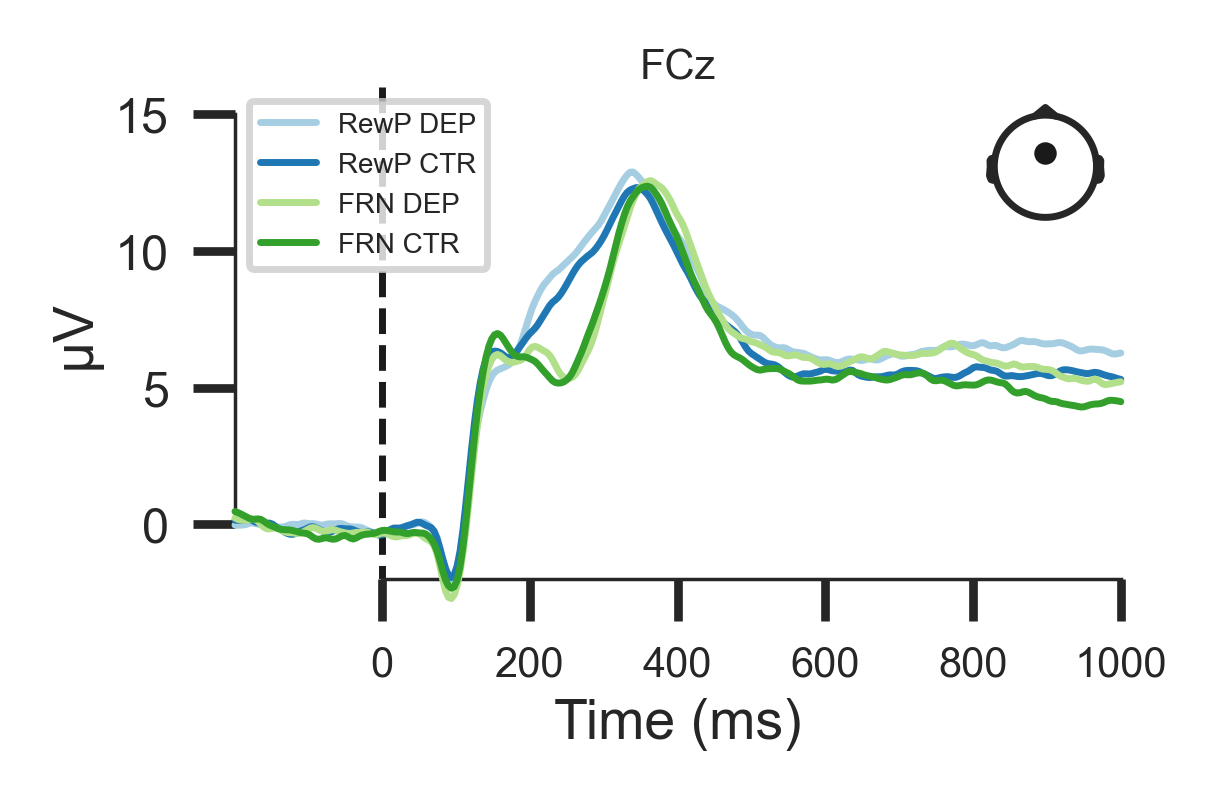

In [33]:
cm = 1/2.54
dpi = 500

plt.rc('font', size=4)
sns.set_style("ticks")


plt.rcParams['figure.dpi'] = dpi
# plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['ytick.labelsize'] = 7
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['axes.labelsize'] = 8
plt.rcParams["axes.edgecolor"] = ".15"
plt.rcParams["axes.linewidth"]  = 0.5
plt.rcParams['lines.linewidth'] = 1

plt.rcParams['axes.spines.bottom']= True
plt.rcParams['axes.spines.left']= True
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True

plt.rcParams['axes.titlesize'] = 6
plt.rcParams['figure.frameon'] = True
plt.rc('legend',fontsize=4)

plt.rcParams['axes.titlepad'] = 0.2
plt.rcParams['axes.labelpad'] = 2
plt.rcParams['axes.titlepad'] = 0.2



sns.set_palette('Paired')

picks = ["FCz"]

# fig = plt.figure()
# ax = fig.add_axes([0, 0, 0.78, 0.78])

fig = plt.figure(figsize=(4.5*cm, 2.5*cm))

ax = fig.add_axes([0,0,1,1], zorder=-1)
# topo_rewP_axis = fig.add_axes([0.76,0.67,0.32,0.32], zorder=1000)
# topo_FRN_axis = fig.add_axes([0.76,0.02,0.32,0.32], zorder=10000)


# rewp_fig, rewP_cont = mne.viz.plot_topomap(
#     rewp_delta_contrast.reshape(-1), 
#     evokeds_dep[0].info, 
#     show=False, 
#     res=1000, 
#     sensors=False,
#     axes=topo_rewP_axis
# )
# plt.setp(rewP_cont.collections , linewidth=0.5)
# plt.setp(topo_rewP_axis.lines , linewidth=0.5)


# frn_fig, frn_cont = mne.viz.plot_topomap(
#     frn_delta_contrast.reshape(-1), 
#     evokeds_dep[0].info, 
#     show=False, 
#     res=1000, 
#     sensors=False,
#     axes=topo_FRN_axis
# )
# plt.setp(frn_cont.collections , linewidth=0.5)
# plt.setp(topo_FRN_axis.lines , linewidth=0.5)



a = mne.viz.plot_compare_evokeds(
    evokeds, 
    picks=picks, 
    ci=0.95, 
    ylim=dict(eeg=[-2, 16]),
    axes=ax,
    time_unit='ms',
)


# fig.savefig(f'data/theta_anx', bbox_inches='tight', pad_inches=0.01)

In [20]:
%%capture
data_df['theta35'] = data_df['epochs'].apply(lambda x: x.copy().filter(
    3.5, 
    8.0, 
    fir_design='firwin', 
    skip_by_annotation='edge',
    h_trans_bandwidth = 'auto',
))

In [21]:
dep = data_df[(data_df['BDI'] > 14) & (data_df['STAI'] > 41)]
len(dep)

67

In [22]:
ctrl_dep = data_df[(data_df['BDI'] <= 12) & (data_df['STAI'] > 41)]
len(ctrl_dep)

68

In [23]:
depression_epochs = mne.concatenate_epochs(dep['theta35'].to_list())
depression_ctr_epochs = mne.concatenate_epochs(ctrl_dep['theta35'].to_list())

/tmp/ipykernel_3822/2409067025.py:1: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  depression_epochs = mne.concatenate_epochs(dep['theta35'].to_list())


Not setting metadata
16623 matching events found
No baseline correction applied


/tmp/ipykernel_3822/2409067025.py:2: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  depression_ctr_epochs = mne.concatenate_epochs(ctrl_dep['theta35'].to_list())


Not setting metadata
16658 matching events found
No baseline correction applied


In [24]:
evokeds_dep = [depression_epochs[name].average() for name in ('f_good', 'f_bad')]
evokeds_dep_ctr = [depression_ctr_epochs[name].average() for name in ('f_good', 'f_bad')]

evokeds = {
    'RewP DEP': evokeds_dep[0],
    'RewP CTR': evokeds_dep_ctr[0],
    'FRN DEP' : evokeds_dep[1],
    'FRN CTR' : evokeds_dep_ctr[1],
}

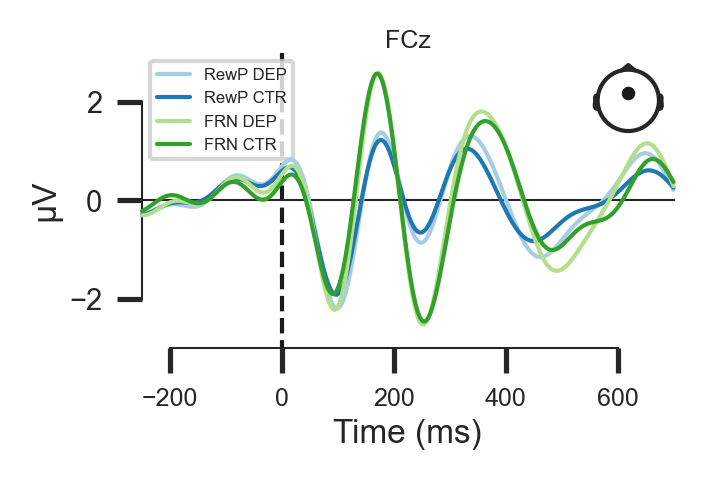

In [25]:
cm = 1/2.54
dpi = 300

plt.rc('font', size=4)
sns.set_style("ticks")


plt.rcParams['figure.dpi'] = dpi
# plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['ytick.labelsize'] = 7
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['axes.labelsize'] = 8
plt.rcParams["axes.edgecolor"] = ".15"
plt.rcParams["axes.linewidth"]  = 0.5
plt.rcParams['lines.linewidth'] = 1

plt.rcParams['axes.spines.bottom']= True
plt.rcParams['axes.spines.left']= True
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True

plt.rcParams['axes.titlesize'] = 6
plt.rcParams['figure.frameon'] = True
plt.rc('legend',fontsize=4)

plt.rcParams['axes.titlepad'] = 0.2
plt.rcParams['axes.labelpad'] = 2
plt.rcParams['axes.titlepad'] = 0.2



sns.set_palette('Paired')

picks = ["FCz"]

# fig = plt.figure()
# ax = fig.add_axes([0, 0, 0.78, 0.78])

fig = plt.figure(figsize=(4.5*cm, 2.5*cm))

ax = fig.add_axes([0,0,1,1], zorder=-1)
# topo_rewP_axis = fig.add_axes([0.76,0.67,0.32,0.32], zorder=1000)
# topo_FRN_axis = fig.add_axes([0.76,0.02,0.32,0.32], zorder=10000)


# rewp_fig, rewP_cont = mne.viz.plot_topomap(
#     rewp_delta_contrast.reshape(-1), 
#     evokeds_dep[0].info, 
#     show=False, 
#     res=1000, 
#     sensors=False,
#     axes=topo_rewP_axis
# )
# plt.setp(rewP_cont.collections , linewidth=0.5)
# plt.setp(topo_rewP_axis.lines , linewidth=0.5)


# frn_fig, frn_cont = mne.viz.plot_topomap(
#     frn_delta_contrast.reshape(-1), 
#     evokeds_dep[0].info, 
#     show=False, 
#     res=1000, 
#     sensors=False,
#     axes=topo_FRN_axis
# )
# plt.setp(frn_cont.collections , linewidth=0.5)
# plt.setp(topo_FRN_axis.lines , linewidth=0.5)



a = mne.viz.plot_compare_evokeds(
    evokeds, 
    picks=picks, 
    ci=0.95, 
    ylim=dict(eeg=[-3, 3]),
    axes=ax,
    time_unit='ms',
)


# fig.savefig(f'data/theta_dep', bbox_inches='tight', pad_inches=0.01)

In [26]:
%%capture
data_df['theta3-9'] = data_df['epochs'].apply(lambda x: x.copy().filter(
    3.0, 
    9.0, 
    fir_design='firwin', 
    skip_by_annotation='edge',
    h_trans_bandwidth = 'auto',
))

In [27]:
dep = data_df[(data_df['BDI'] > 14) & (data_df['STAI'] > 41)]
len(dep)

67

In [28]:
ctrl_dep = data_df[(data_df['BDI'] <= 12) & (data_df['STAI'] > 41)]
len(ctrl_dep)

68

In [29]:
depression_epochs = mne.concatenate_epochs(dep['theta3-9'].to_list())
depression_ctr_epochs = mne.concatenate_epochs(ctrl_dep['theta3-9'].to_list())

/tmp/ipykernel_3822/3125140204.py:1: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  depression_epochs = mne.concatenate_epochs(dep['theta3-9'].to_list())


Not setting metadata
16623 matching events found
No baseline correction applied


/tmp/ipykernel_3822/3125140204.py:2: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  depression_ctr_epochs = mne.concatenate_epochs(ctrl_dep['theta3-9'].to_list())


Not setting metadata
16658 matching events found
No baseline correction applied


In [30]:
evokeds_dep = [depression_epochs[name].average() for name in ('f_good', 'f_bad')]
evokeds_dep_ctr = [depression_ctr_epochs[name].average() for name in ('f_good', 'f_bad')]

evokeds = {
    'RewP DEP': evokeds_dep[0],
    'RewP CTR': evokeds_dep_ctr[0],
    'FRN DEP' : evokeds_dep[1],
    'FRN CTR' : evokeds_dep_ctr[1],
}

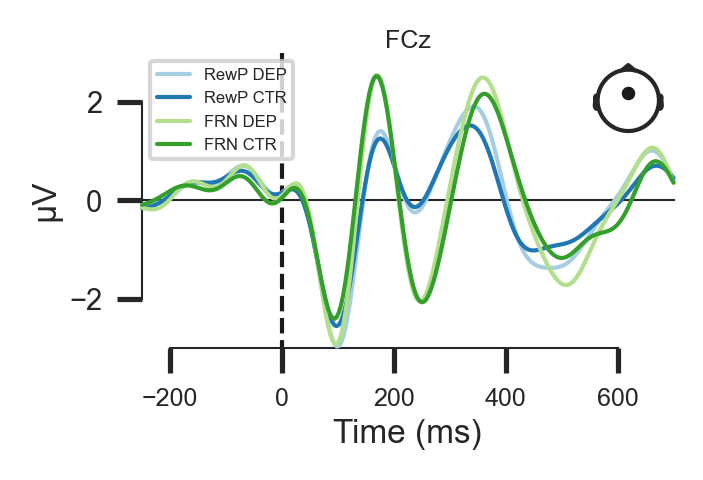

In [31]:
cm = 1/2.54
dpi = 300

plt.rc('font', size=4)
sns.set_style("ticks")


plt.rcParams['figure.dpi'] = dpi
# plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['ytick.labelsize'] = 7
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['axes.labelsize'] = 8
plt.rcParams["axes.edgecolor"] = ".15"
plt.rcParams["axes.linewidth"]  = 0.5
plt.rcParams['lines.linewidth'] = 1

plt.rcParams['axes.spines.bottom']= True
plt.rcParams['axes.spines.left']= True
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True

plt.rcParams['axes.titlesize'] = 6
plt.rcParams['figure.frameon'] = True
plt.rc('legend',fontsize=4)

plt.rcParams['axes.titlepad'] = 0.2
plt.rcParams['axes.labelpad'] = 2
plt.rcParams['axes.titlepad'] = 0.2



sns.set_palette('Paired')

picks = ["FCz"]

# fig = plt.figure()
# ax = fig.add_axes([0, 0, 0.78, 0.78])

fig = plt.figure(figsize=(4.5*cm, 2.5*cm))

ax = fig.add_axes([0,0,1,1], zorder=-1)
# topo_rewP_axis = fig.add_axes([0.76,0.67,0.32,0.32], zorder=1000)
# topo_FRN_axis = fig.add_axes([0.76,0.02,0.32,0.32], zorder=10000)


# rewp_fig, rewP_cont = mne.viz.plot_topomap(
#     rewp_delta_contrast.reshape(-1), 
#     evokeds_dep[0].info, 
#     show=False, 
#     res=1000, 
#     sensors=False,
#     axes=topo_rewP_axis
# )
# plt.setp(rewP_cont.collections , linewidth=0.5)
# plt.setp(topo_rewP_axis.lines , linewidth=0.5)


# frn_fig, frn_cont = mne.viz.plot_topomap(
#     frn_delta_contrast.reshape(-1), 
#     evokeds_dep[0].info, 
#     show=False, 
#     res=1000, 
#     sensors=False,
#     axes=topo_FRN_axis
# )
# plt.setp(frn_cont.collections , linewidth=0.5)
# plt.setp(topo_FRN_axis.lines , linewidth=0.5)



a = mne.viz.plot_compare_evokeds(
    evokeds, 
    picks=picks, 
    ci=0.95, 
    ylim=dict(eeg=[-3, 3]),
    axes=ax,
    time_unit='ms',
)


# fig.savefig(f'data/theta_dep', bbox_inches='tight', pad_inches=0.01)

In [48]:
%%capture
data_df['theta'] = data_df['epochs'].apply(lambda x: x.copy().filter(
    4.0, 
    10.0, 
    fir_design='firwin', 
    skip_by_annotation='edge',
    h_trans_bandwidth = 'auto',
))

In [54]:
anx = data_df[(data_df['BDI'] <= 13) & (data_df['STAI'] > 42)]
len(anx)

66

In [55]:
ctrl_anx = data_df[(data_df['BDI'] <= 13) & (data_df['STAI'] < 41)]
len(ctrl_anx)

65

In [59]:
depression_epochs = mne.concatenate_epochs(anx['theta35'].to_list())
depression_ctr_epochs = mne.concatenate_epochs(ctrl_anx['theta35'].to_list())

/tmp/ipykernel_3822/2088837195.py:1: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  depression_epochs = mne.concatenate_epochs(anx['theta35'].to_list())


Not setting metadata
16160 matching events found
No baseline correction applied


/tmp/ipykernel_3822/2088837195.py:2: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  depression_ctr_epochs = mne.concatenate_epochs(ctrl_anx['theta35'].to_list())


Not setting metadata
16182 matching events found
No baseline correction applied


In [60]:
evokeds_dep = [depression_epochs[name].average() for name in ('f_good', 'f_bad')]
evokeds_dep_ctr = [depression_ctr_epochs[name].average() for name in ('f_good', 'f_bad')]

evokeds = {
    'RewP DEP': evokeds_dep[0],
    'RewP CTR': evokeds_dep_ctr[0],
    'FRN DEP' : evokeds_dep[1],
    'FRN CTR' : evokeds_dep_ctr[1],
}

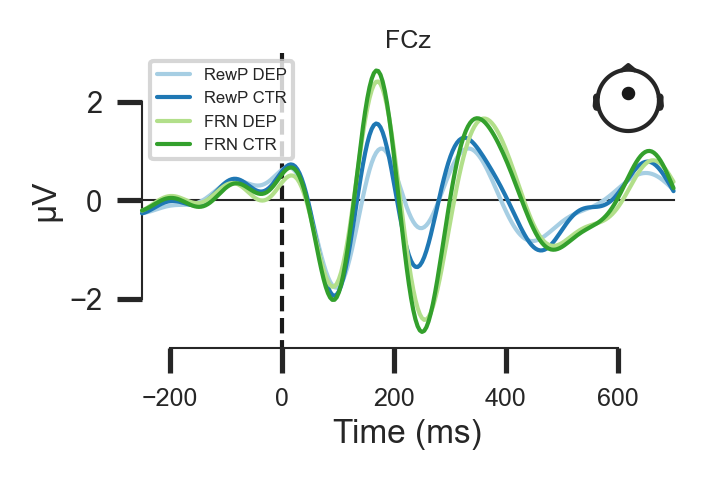

In [61]:
cm = 1/2.54
dpi = 300

plt.rc('font', size=4)
sns.set_style("ticks")


plt.rcParams['figure.dpi'] = dpi
# plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['ytick.labelsize'] = 7
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['axes.labelsize'] = 8
plt.rcParams["axes.edgecolor"] = ".15"
plt.rcParams["axes.linewidth"]  = 0.5
plt.rcParams['lines.linewidth'] = 1

plt.rcParams['axes.spines.bottom']= True
plt.rcParams['axes.spines.left']= True
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True

plt.rcParams['axes.titlesize'] = 6
plt.rcParams['figure.frameon'] = True
plt.rc('legend',fontsize=4)

plt.rcParams['axes.titlepad'] = 0.2
plt.rcParams['axes.labelpad'] = 2
plt.rcParams['axes.titlepad'] = 0.2



sns.set_palette('Paired')

picks = ["FCz"]

# fig = plt.figure()
# ax = fig.add_axes([0, 0, 0.78, 0.78])

fig = plt.figure(figsize=(4.5*cm, 2.5*cm))

ax = fig.add_axes([0,0,1,1], zorder=-1)
# topo_rewP_axis = fig.add_axes([0.76,0.67,0.32,0.32], zorder=1000)
# topo_FRN_axis = fig.add_axes([0.76,0.02,0.32,0.32], zorder=10000)


# rewp_fig, rewP_cont = mne.viz.plot_topomap(
#     rewp_delta_contrast.reshape(-1), 
#     evokeds_dep[0].info, 
#     show=False, 
#     res=1000, 
#     sensors=False,
#     axes=topo_rewP_axis
# )
# plt.setp(rewP_cont.collections , linewidth=0.5)
# plt.setp(topo_rewP_axis.lines , linewidth=0.5)


# frn_fig, frn_cont = mne.viz.plot_topomap(
#     frn_delta_contrast.reshape(-1), 
#     evokeds_dep[0].info, 
#     show=False, 
#     res=1000, 
#     sensors=False,
#     axes=topo_FRN_axis
# )
# plt.setp(frn_cont.collections , linewidth=0.5)
# plt.setp(topo_FRN_axis.lines , linewidth=0.5)



a = mne.viz.plot_compare_evokeds(
    evokeds, 
    picks=picks, 
    ci=0.95, 
    ylim=dict(eeg=[-3, 3]),
    axes=ax,
    time_unit='ms',
)


# fig.savefig(f'data/theta_dep', bbox_inches='tight', pad_inches=0.01)

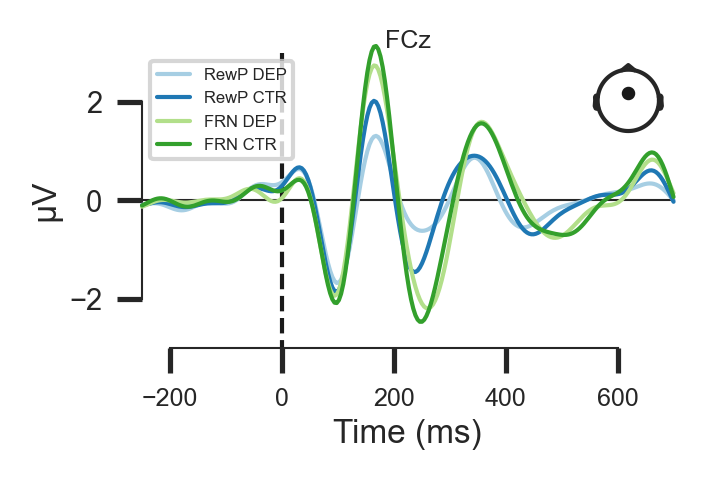

In [58]:
cm = 1/2.54
dpi = 300

plt.rc('font', size=4)
sns.set_style("ticks")


plt.rcParams['figure.dpi'] = dpi
# plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['ytick.labelsize'] = 7
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['axes.labelsize'] = 8
plt.rcParams["axes.edgecolor"] = ".15"
plt.rcParams["axes.linewidth"]  = 0.5
plt.rcParams['lines.linewidth'] = 1

plt.rcParams['axes.spines.bottom']= True
plt.rcParams['axes.spines.left']= True
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True

plt.rcParams['axes.titlesize'] = 6
plt.rcParams['figure.frameon'] = True
plt.rc('legend',fontsize=4)

plt.rcParams['axes.titlepad'] = 0.2
plt.rcParams['axes.labelpad'] = 2
plt.rcParams['axes.titlepad'] = 0.2



sns.set_palette('Paired')

picks = ["FCz"]

# fig = plt.figure()
# ax = fig.add_axes([0, 0, 0.78, 0.78])

fig = plt.figure(figsize=(4.5*cm, 2.5*cm))

ax = fig.add_axes([0,0,1,1], zorder=-1)
# topo_rewP_axis = fig.add_axes([0.76,0.67,0.32,0.32], zorder=1000)
# topo_FRN_axis = fig.add_axes([0.76,0.02,0.32,0.32], zorder=10000)


# rewp_fig, rewP_cont = mne.viz.plot_topomap(
#     rewp_delta_contrast.reshape(-1), 
#     evokeds_dep[0].info, 
#     show=False, 
#     res=1000, 
#     sensors=False,
#     axes=topo_rewP_axis
# )
# plt.setp(rewP_cont.collections , linewidth=0.5)
# plt.setp(topo_rewP_axis.lines , linewidth=0.5)


# frn_fig, frn_cont = mne.viz.plot_topomap(
#     frn_delta_contrast.reshape(-1), 
#     evokeds_dep[0].info, 
#     show=False, 
#     res=1000, 
#     sensors=False,
#     axes=topo_FRN_axis
# )
# plt.setp(frn_cont.collections , linewidth=0.5)
# plt.setp(topo_FRN_axis.lines , linewidth=0.5)



a = mne.viz.plot_compare_evokeds(
    evokeds, 
    picks=picks, 
    ci=0.95, 
    ylim=dict(eeg=[-3, 3]),
    axes=ax,
    time_unit='ms',
)


# fig.savefig(f'data/theta_dep', bbox_inches='tight', pad_inches=0.01)

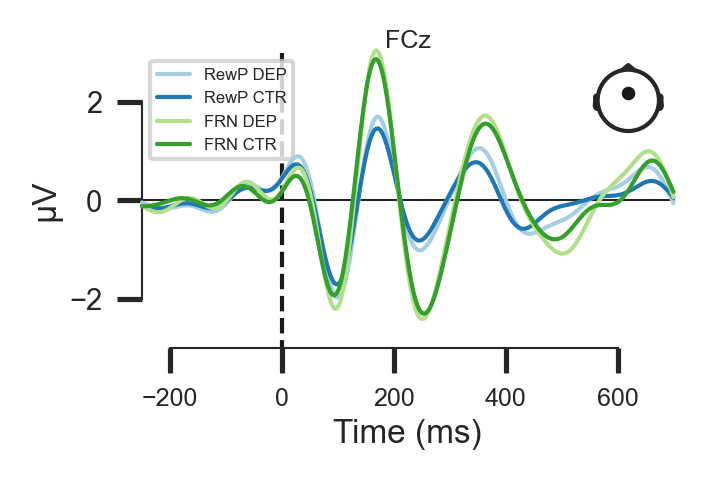

In [21]:
cm = 1/2.54
dpi = 300

plt.rc('font', size=4)
sns.set_style("ticks")


plt.rcParams['figure.dpi'] = dpi
# plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['ytick.labelsize'] = 7
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['axes.labelsize'] = 8
plt.rcParams["axes.edgecolor"] = ".15"
plt.rcParams["axes.linewidth"]  = 0.5
plt.rcParams['lines.linewidth'] = 1

plt.rcParams['axes.spines.bottom']= True
plt.rcParams['axes.spines.left']= True
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True

plt.rcParams['axes.titlesize'] = 6
plt.rcParams['figure.frameon'] = True
plt.rc('legend',fontsize=4)

plt.rcParams['axes.titlepad'] = 0.2
plt.rcParams['axes.labelpad'] = 2
plt.rcParams['axes.titlepad'] = 0.2



sns.set_palette('Paired')

picks = ["FCz"]

# fig = plt.figure()
# ax = fig.add_axes([0, 0, 0.78, 0.78])

fig = plt.figure(figsize=(4.5*cm, 2.5*cm))

ax = fig.add_axes([0,0,1,1], zorder=-1)
# topo_rewP_axis = fig.add_axes([0.76,0.67,0.32,0.32], zorder=1000)
# topo_FRN_axis = fig.add_axes([0.76,0.02,0.32,0.32], zorder=10000)


# rewp_fig, rewP_cont = mne.viz.plot_topomap(
#     rewp_delta_contrast.reshape(-1), 
#     evokeds_dep[0].info, 
#     show=False, 
#     res=1000, 
#     sensors=False,
#     axes=topo_rewP_axis
# )
# plt.setp(rewP_cont.collections , linewidth=0.5)
# plt.setp(topo_rewP_axis.lines , linewidth=0.5)


# frn_fig, frn_cont = mne.viz.plot_topomap(
#     frn_delta_contrast.reshape(-1), 
#     evokeds_dep[0].info, 
#     show=False, 
#     res=1000, 
#     sensors=False,
#     axes=topo_FRN_axis
# )
# plt.setp(frn_cont.collections , linewidth=0.5)
# plt.setp(topo_FRN_axis.lines , linewidth=0.5)



a = mne.viz.plot_compare_evokeds(
    evokeds, 
    picks=picks, 
    ci=0.95, 
    ylim=dict(eeg=[-3, 3]),
    axes=ax,
    time_unit='ms',
)


# fig.savefig(f'data/theta_dep', bbox_inches='tight', pad_inches=0.01)

## Visualize anxiety vs control brain activity

### Delta

In [9]:
anxiety_epochs = mne.concatenate_epochs(anx['delta'].to_list())
anxiety_ctr_epochs = mne.concatenate_epochs(ctrl_anx['delta'].to_list())

/tmp/ipykernel_3772/3204259360.py:1: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  anxiety_epochs = mne.concatenate_epochs(anx['delta'].to_list())


Not setting metadata
15837 matching events found
No baseline correction applied


/tmp/ipykernel_3772/3204259360.py:2: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  anxiety_ctr_epochs = mne.concatenate_epochs(ctrl_anx['delta'].to_list())


Not setting metadata
16161 matching events found
No baseline correction applied


In [10]:
evokeds_anx = [anxiety_epochs[name].average() for name in ('f_good', 'f_bad')]
evokeds_anx_ctr = [anxiety_ctr_epochs[name].average() for name in ('f_good', 'f_bad')]

evokeds = {
    'RewP ANX': evokeds_anx[0],
    'RewP CTR': evokeds_anx_ctr[0],
    'FRN ANX' : evokeds_anx[1],
    'FRN CTR' : evokeds_anx_ctr[1],
}

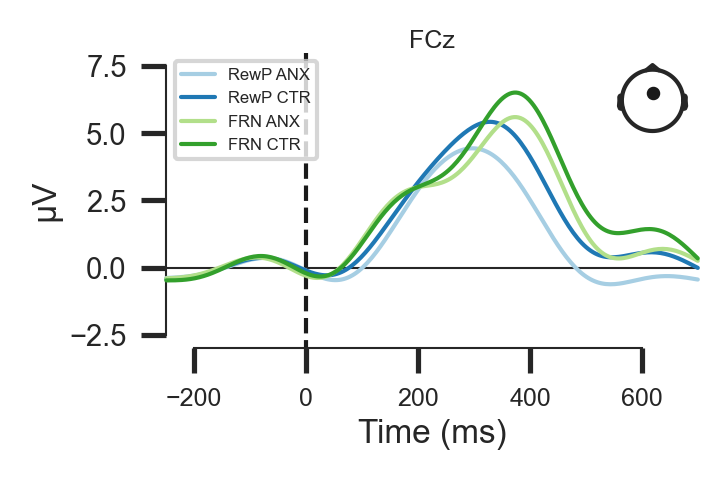

In [13]:
cm = 1/2.54
dpi = 300

plt.rc('font', size=4)
sns.set_style("ticks")


plt.rcParams['figure.dpi'] = dpi
# plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['ytick.labelsize'] = 7
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['axes.labelsize'] = 8
plt.rcParams["axes.edgecolor"] = ".15"
plt.rcParams["axes.linewidth"]  = 0.5
plt.rcParams['lines.linewidth'] = 1

plt.rcParams['axes.spines.bottom']= True
plt.rcParams['axes.spines.left']= True
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True

plt.rcParams['axes.titlesize'] = 6
plt.rcParams['figure.frameon'] = True
plt.rc('legend',fontsize=4)

plt.rcParams['axes.titlepad'] = 0.2
plt.rcParams['axes.labelpad'] = 2
plt.rcParams['axes.titlepad'] = 0.2



sns.set_palette('Paired')

picks = ["FCz"]

# fig = plt.figure()
# ax = fig.add_axes([0, 0, 0.78, 0.78])

fig = plt.figure(figsize=(4.5*cm, 2.5*cm))

ax = fig.add_axes([0,0,1,1], zorder=-1)
# topo_rewP_axis = fig.add_axes([0.76,0.67,0.32,0.32], zorder=1000)
# topo_FRN_axis = fig.add_axes([0.76,0.02,0.32,0.32], zorder=10000)


# rewp_fig, rewP_cont = mne.viz.plot_topomap(
#     rewp_delta_contrast.reshape(-1), 
#     evokeds_anx[0].info, 
#     show=False, 
#     res=1000, 
#     sensors=False,
#     axes=topo_rewP_axis
# )
# plt.setp(rewP_cont.collections , linewidth=0.5)
# plt.setp(topo_rewP_axis.lines , linewidth=0.5)


# frn_fig, frn_cont = mne.viz.plot_topomap(
#     frn_delta_contrast.reshape(-1), 
#     evokeds_anx[0].info, 
#     show=False, 
#     res=1000, 
#     sensors=False,
#     axes=topo_FRN_axis
# )
# plt.setp(frn_cont.collections , linewidth=0.5)
# plt.setp(topo_FRN_axis.lines , linewidth=0.5)



a = mne.viz.plot_compare_evokeds(
    evokeds, 
    picks=picks, 
    ci=0.95, 
    ylim=dict(eeg=[-3, 8]),
    axes=ax,
    time_unit='ms',
)


# fig.savefig(f'data/delta_anx', bbox_inches='tight', pad_inches=0.01)

### Theta

In [14]:
anxiety_epochs = mne.concatenate_epochs(anx['theta'].to_list())
anxiety_ctr_epochs = mne.concatenate_epochs(ctrl_anx['theta'].to_list())

/tmp/ipykernel_3772/274733208.py:1: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  anxiety_epochs = mne.concatenate_epochs(anx['theta'].to_list())


Not setting metadata
15837 matching events found
No baseline correction applied


/tmp/ipykernel_3772/274733208.py:2: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  anxiety_ctr_epochs = mne.concatenate_epochs(ctrl_anx['theta'].to_list())


Not setting metadata
16161 matching events found
No baseline correction applied


In [15]:
evokeds_anx = [anxiety_epochs[name].average() for name in ('f_good', 'f_bad')]
evokeds_anx_ctr = [anxiety_ctr_epochs[name].average() for name in ('f_good', 'f_bad')]

evokeds = {
    'RewP ANX': evokeds_anx[0],
    'RewP CTR': evokeds_anx_ctr[0],
    'FRN ANX' : evokeds_anx[1],
    'FRN CTR' : evokeds_anx_ctr[1],
}

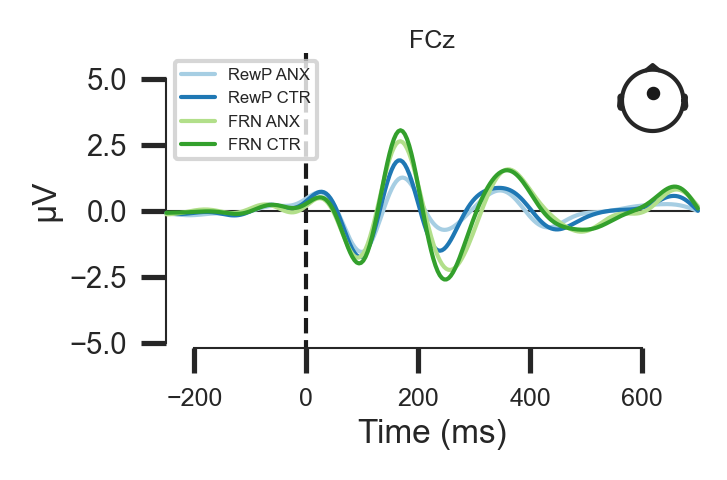

In [16]:
cm = 1/2.54
dpi = 300

plt.rc('font', size=4)
sns.set_style("ticks")


plt.rcParams['figure.dpi'] = dpi
# plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['ytick.labelsize'] = 7
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['axes.labelsize'] = 8
plt.rcParams["axes.edgecolor"] = ".15"
plt.rcParams["axes.linewidth"]  = 0.5
plt.rcParams['lines.linewidth'] = 1

plt.rcParams['axes.spines.bottom']= True
plt.rcParams['axes.spines.left']= True
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True

plt.rcParams['axes.titlesize'] = 6
plt.rcParams['figure.frameon'] = True
plt.rc('legend',fontsize=4)

plt.rcParams['axes.titlepad'] = 0.2
plt.rcParams['axes.labelpad'] = 2
plt.rcParams['axes.titlepad'] = 0.2



sns.set_palette('Paired')

picks = ["FCz"]

# fig = plt.figure()
# ax = fig.add_axes([0, 0, 0.78, 0.78])

fig = plt.figure(figsize=(4.5*cm, 2.5*cm))

ax = fig.add_axes([0,0,1,1], zorder=-1)
# topo_rewP_axis = fig.add_axes([0.76,0.67,0.32,0.32], zorder=1000)
# topo_FRN_axis = fig.add_axes([0.76,0.02,0.32,0.32], zorder=10000)


# rewp_fig, rewP_cont = mne.viz.plot_topomap(
#     rewp_delta_contrast.reshape(-1), 
#     evokeds_anx[0].info, 
#     show=False, 
#     res=1000, 
#     sensors=False,
#     axes=topo_rewP_axis
# )
# plt.setp(rewP_cont.collections , linewidth=0.5)
# plt.setp(topo_rewP_axis.lines , linewidth=0.5)


# frn_fig, frn_cont = mne.viz.plot_topomap(
#     frn_delta_contrast.reshape(-1), 
#     evokeds_anx[0].info, 
#     show=False, 
#     res=1000, 
#     sensors=False,
#     axes=topo_FRN_axis
# )
# plt.setp(frn_cont.collections , linewidth=0.5)
# plt.setp(topo_FRN_axis.lines , linewidth=0.5)



a = mne.viz.plot_compare_evokeds(
    evokeds, 
    picks=picks, 
    ci=0.95, 
    ylim=dict(eeg=[-5.2, 6]),
    axes=ax,
    time_unit='ms',
)


# fig.savefig(f'data/theta_anx', bbox_inches='tight', pad_inches=0.01)